In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl

# ========== 1) 获取 2021 赛季赛程数据 ==========
schedules = nfl.import_schedules([2021])  # 包含比分
print(f"原始赛程数据行数: {len(schedules)}")
schedules.head()

# ========== 2) 拆成每队一行，计算胜负 ==========
home = schedules.copy()
home["team"] = home["home_team"]
home["opponent"] = home["away_team"]
home["team_score"] = home["home_score"]
home["opp_score"] = home["away_score"]

away = schedules.copy()
away["team"] = away["away_team"]
away["opponent"] = away["home_team"]
away["team_score"] = away["away_score"]
away["opp_score"] = away["home_score"]

games = pd.concat([home, away], ignore_index=True)

def wl(row):
    if pd.isna(row["team_score"]) or pd.isna(row["opp_score"]):
        return np.nan
    if row["team_score"] > row["opp_score"]:
        return "W"
    elif row["team_score"] < row["opp_score"]:
        return "L"
    else:
        return "T"

games["win_loss"] = games.apply(wl, axis=1)

# 只取常规赛
games_reg = games[games["game_type"] == "REG"].sort_values(["team", "week"])

# ========== 3) 计算连败片段 ==========
def losing_streak_segments(team_df):
    out = []
    streak = 0
    weeks_run, opps_run = [], []
    for _, r in team_df.iterrows():
        res = r["win_loss"]
        if res == "L":
            streak += 1
            weeks_run.append(int(r["week"]))
            opps_run.append(r["opponent"])
        else:
            if streak > 0:
                out.append({
                    "start_week": weeks_run[0],
                    "end_week": weeks_run[-1],
                    "length": streak,
                    "weeks": weeks_run.copy(),
                    "opponents": opps_run.copy()
                })
            streak = 0
            weeks_run, opps_run = [], []
    if streak > 0:
        out.append({
            "start_week": weeks_run[0],
            "end_week": weeks_run[-1],
            "length": streak,
            "weeks": weeks_run.copy(),
            "opponents": opps_run.copy()
        })
    return out

team_streaks = []
segments_rows = []

for team, sub in games_reg.groupby("team"):
    segs = losing_streak_segments(sub)
    max_len = max([s["length"] for s in segs], default=0)
    if max_len > 0:
        first_max = next(s for s in segs if s["length"] == max_len)
        max_span = f"{first_max['start_week']}-{first_max['end_week']}"
    else:
        max_span = ""
    team_streaks.append({
        "team": team,
        "max_losing_streak": max_len,
        "max_span_weeks": max_span
    })
    for s in segs:
        segments_rows.append({
            "team": team,
            "start_week": s["start_week"],
            "end_week": s["end_week"],
            "length": s["length"],
            "weeks": ",".join(map(str, s["weeks"])),
            "opponents": ",".join(s["opponents"])
        })

df_team_streaks = pd.DataFrame(team_streaks).sort_values("max_losing_streak", ascending=False)
df_segments = pd.DataFrame(segments_rows)

# ========== 4) 关键比赛胜率（最后 4 周） ==========
max_week = int(games_reg["week"].max())
cutoff = max_week - 4 + 1
key_games = games_reg[games_reg["week"] >= cutoff]

key_stats = []
for team, sub in key_games.groupby("team"):
    w = (sub["win_loss"] == "W").sum()
    l = (sub["win_loss"] == "L").sum()
    t = (sub["win_loss"] == "T").sum()
    denom = w + l
    winrate = w / denom if denom > 0 else np.nan
    key_stats.append({
        "team": team,
        "wins": w, "losses": l, "ties": t,
        "winrate": winrate
    })
df_key_win = pd.DataFrame(key_stats).sort_values("winrate", ascending=True)

# ========== 5) 输出结果 ==========
print("\n=== 每队最大连败（2021） ===")
display(df_team_streaks)

print("\n=== 连败片段明细（2021） ===")
display(df_segments)

print("\n=== 关键比赛胜率（最后4周） ===")
display(df_key_win)

print("\n=== ≥7 连败球队（宏观瓶颈） ===")
display(df_team_streaks[df_team_streaks["max_losing_streak"] >= 7])


原始赛程数据行数: 285

=== 每队最大连败（2021） ===


team  max_losing_streak max_span_weeks
10  DET                  8            1-8
14  JAX                  8          10-17
12  HOU                  8            2-9
19  MIA                  7            2-8
4   CAR                  7          11-18
2   BAL                  6          13-18
23  NYG                  6          13-18
22   NO                  5           9-13
5   CHI                  5           6-11
31  WAS                  4            5-8
9   DEN                  4            4-7
28   SF                  4            3-7
24  NYJ                  3            1-3
18   LV                  3           9-11
26  PIT                  3            2-4
27  SEA                  3            5-7
25  PHI                  3            2-4
0   ARI                  3          14-16
13  IND                  3            1-3
7   CLE                  3          15-17
16   LA                  3           9-12
17  LAC                  2            6-8
1   ATL                  2            1-2
20  MIN                  2            1-2
21   NE                  2            3-4
15   KC                  2            2-3
8   DAL                  2          11-12
6   CIN                  2            8-9
3   BUF                  2          13-14
29   TB                  2           8-10
30  TEN                  2          11-12
11   GB                  1            1-1


=== 连败片段明细（2021） ===


team  start_week  end_week  length        weeks        opponents
0    ARI           8         8       1            8               GB
1    ARI          10        10       1           10              CAR
2    ARI          14        16       3     14,15,16       LA,DET,IND
3    ARI          18        18       1           18              SEA
4    ATL           1         2       2          1,2           PHI,TB
..   ...         ...       ...     ...          ...              ...
131  TEN          15        15       1           15              PIT
132  WAS           1         1       1            1              LAC
133  WAS           3         3       1            3              BUF
134  WAS           5         8       4      5,6,7,8     NO,KC,GB,DEN
135  WAS          14        17       4  14,15,16,17  DAL,PHI,DAL,PHI

[136 rows x 6 columns]


=== 关键比赛胜率（最后4周） ===


team  wins  losses  ties  winrate
2   BAL     0       4     0     0.00
23  NYG     0       4     0     0.00
4   CAR     0       4     0     0.00
9   DEN     0       4     0     0.00
0   ARI     1       3     0     0.25
24  NYJ     1       3     0     0.25
21   NE     1       3     0     0.25
17  LAC     1       3     0     0.25
14  JAX     1       3     0     0.25
31  WAS     1       3     0     0.25
1   ATL     1       3     0     0.25
7   CLE     1       3     0     0.25
10  DET     2       2     0     0.50
27  SEA     2       2     0     0.50
5   CHI     2       2     0     0.50
20  MIN     2       2     0     0.50
13  IND     2       2     0     0.50
12  HOU     2       2     0     0.50
16   LA     3       1     0     0.75
6   CIN     3       1     0     0.75
19  MIA     3       1     0     0.75
8   DAL     3       1     0     0.75
22   NO     3       1     0     0.75
25  PHI     3       1     0     0.75
26  PIT     3       1     0     0.75
11   GB     3       1     0     0.75
28   SF     3       1     0     0.75
29   TB     3       1     0     0.75
30  TEN     3       1     0     0.75
15   KC     3       1     0     0.75
18   LV     4       0     0     1.00
3   BUF     4       0     0     1.00


=== ≥7 连败球队（宏观瓶颈） ===


team  max_losing_streak max_span_weeks
10  DET                  8            1-8
14  JAX                  8          10-17
12  HOU                  8            2-9
19  MIA                  7            2-8
4   CAR                  7          11-18

=== 瓶颈球队（≥7 连败） ===
   team  max_losing_streak max_span_weeks
10  DET                  8            1-8
12  HOU                  8            2-9
14  JAX                  8          10-17
4   CAR                  7          11-18
19  MIA                  7            2-8

=== 关键比赛（最后4周）胜率 ===
   team  w  l  winrate
2   BAL  0  4     0.00
23  NYG  0  4     0.00
4   CAR  0  4     0.00
9   DEN  0  4     0.00
0   ARI  1  3     0.25
24  NYJ  1  3     0.25
21   NE  1  3     0.25
17  LAC  1  3     0.25
14  JAX  1  3     0.25
31  WAS  1  3     0.25
1   ATL  1  3     0.25
7   CLE  1  3     0.25
10  DET  2  2     0.50
27  SEA  2  2     0.50
5   CHI  2  2     0.50
20  MIN  2  2     0.50
13  IND  2  2     0.50
12  HOU  2  2     0.50
16   LA  3  1     0.75
6   CIN  3  1     0.75
19  MIA  3  1     0.75
8   DAL  3  1     0.75
22   NO  3  1     0.75
25  PHI  3  1     0.75
26  PIT  3  1     0.75
11   GB  3  1     0.75
28   SF  3  1     0.75
29   TB  3  1     0.75
30  TEN  3  1     0.75
15   KC  3  1   

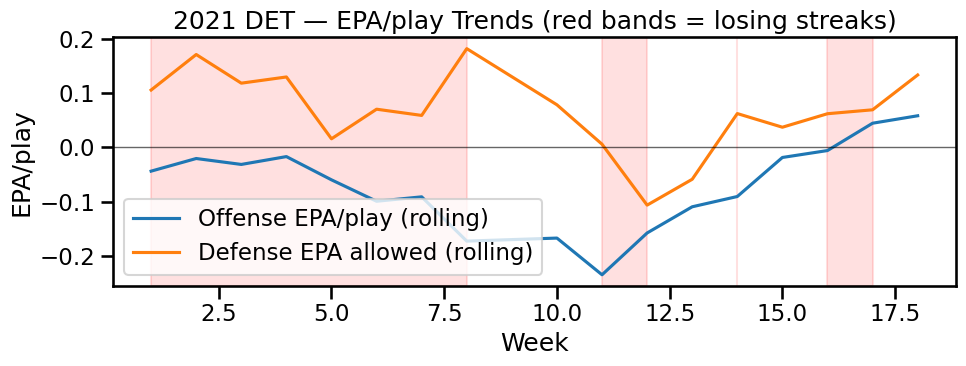

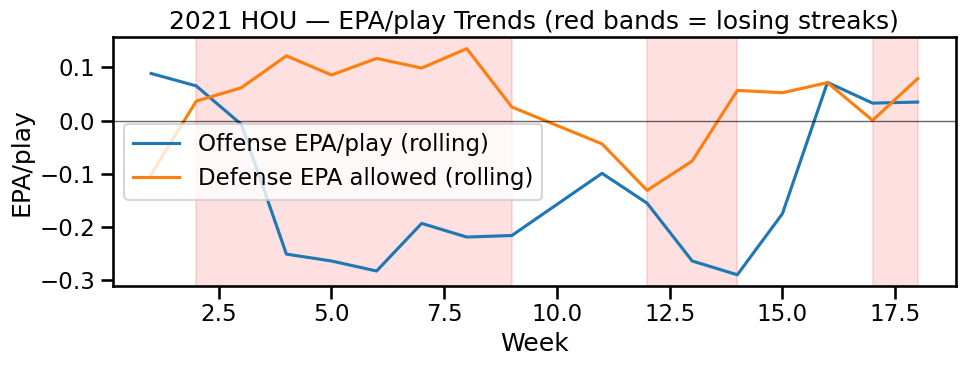

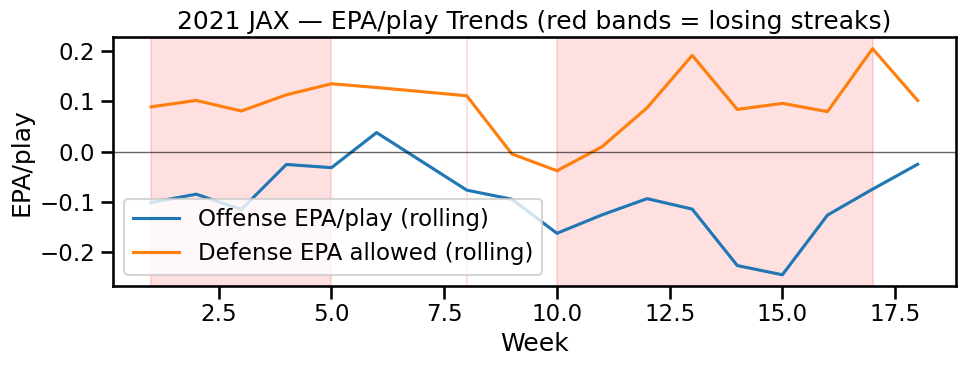

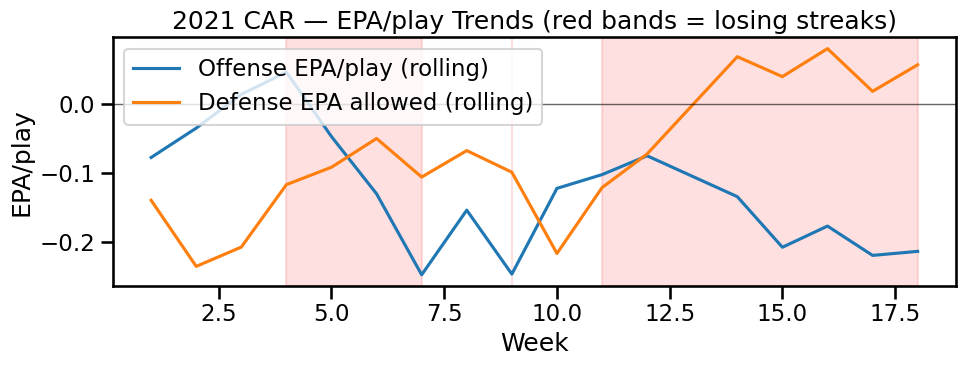

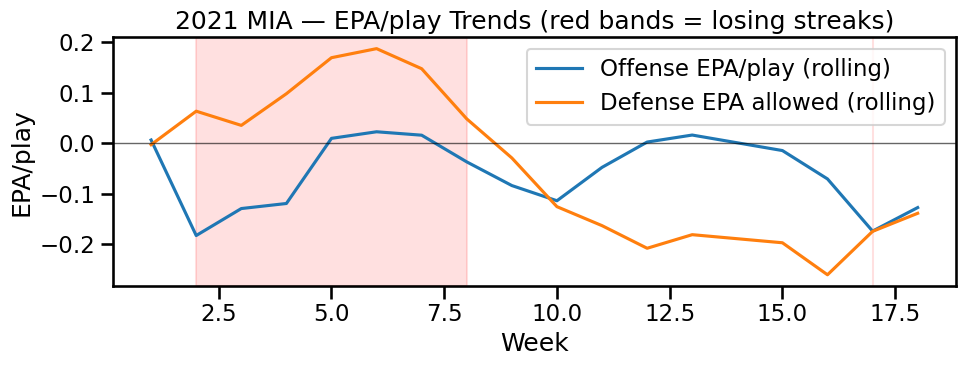

C:\Users\PuhanWang\AppData\Local\Temp\ipykernel_24972\1896865986.py:142: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_local = pd.read_csv(LOCAL_PLAYS)



保护质量统计：
Poor      1273
NaN         16
Medium       3
Good         1
Name: protection_quality, dtype: int64

=== 瓶颈球队内：QB 的目标位置占比与效果（WR/TE/RB） ===
   passer_player_name target_pos_simple  attempts  mean_epa  total     share
0             D.Mills                RB        65 -0.005700    171  0.380117
1             D.Mills                TE        58 -0.094512    171  0.339181
2             D.Mills                WR        48  0.146573    171  0.280702
3          J.Brissett                RB        48 -0.188581    134  0.358209
5          J.Brissett                WR        47  0.130289    134  0.350746
4          J.Brissett                TE        39  0.451949    134  0.291045
6              J.Goff                RB       117 -0.221010    275  0.425455
8              J.Goff                WR        87  0.143242    275  0.316364
7              J.Goff                TE        71  0.237290    275  0.258182
9            P.Walker                RB         9 -0.326381     13  0.692308
11    

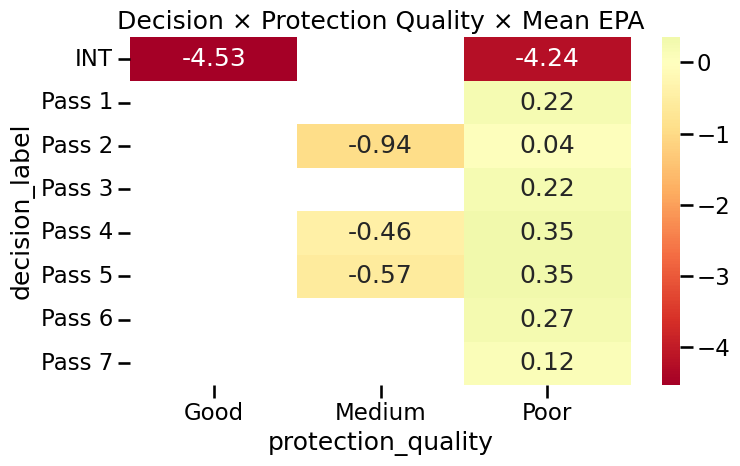

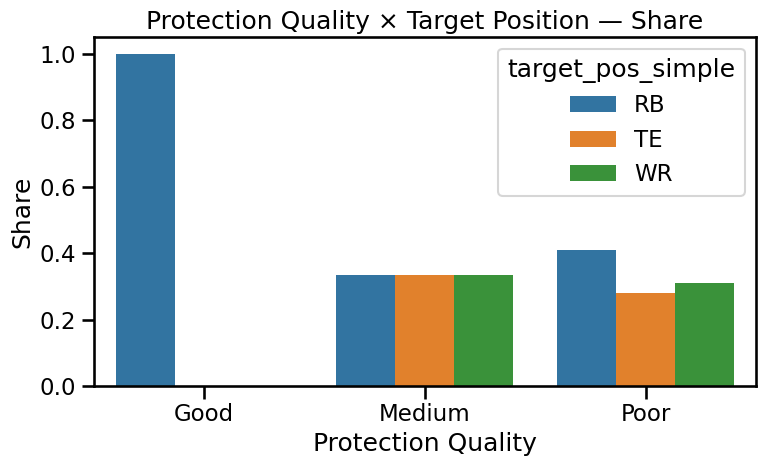

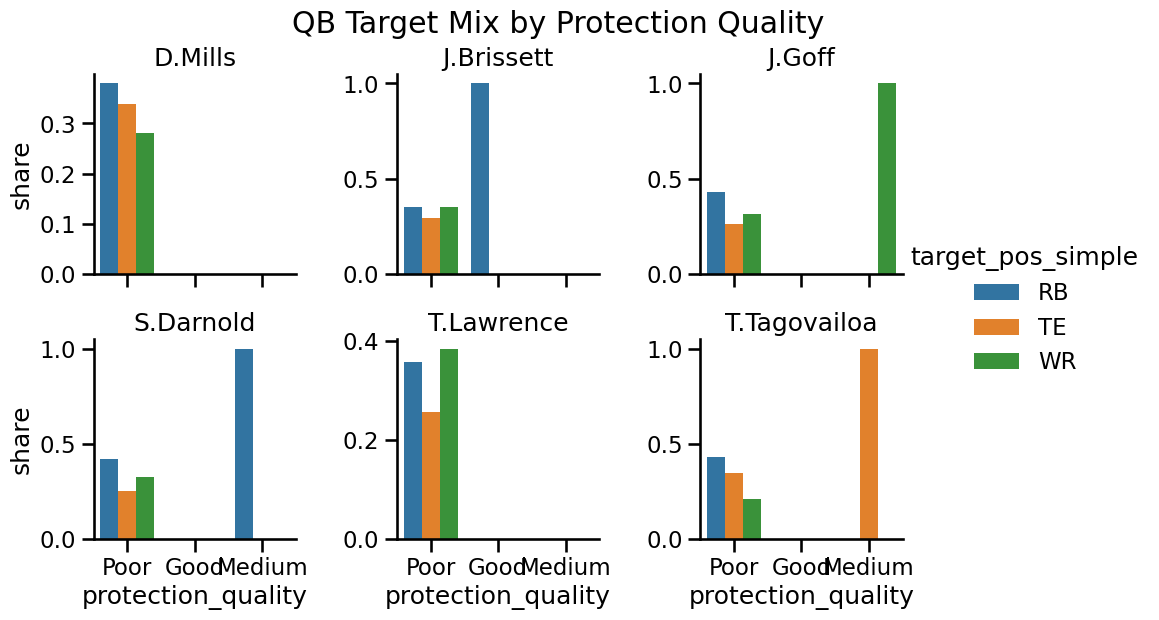


=== Top QBs: Mean EPA by Protection × Target Position ===
   passer_player_name protection_quality target_pos_simple  mean_epa
2             D.Mills               Poor                WR  0.146573
0             D.Mills               Poor                RB -0.005700
1             D.Mills               Poor                TE -0.094512
3          J.Brissett               Good                RB -4.527532
5          J.Brissett               Poor                TE  0.451949
6          J.Brissett               Poor                WR  0.130289
4          J.Brissett               Poor                RB -0.096263
7              J.Goff             Medium                WR -0.459567
9              J.Goff               Poor                TE  0.237290
10             J.Goff               Poor                WR  0.150251
8              J.Goff               Poor                RB -0.221010
11          S.Darnold             Medium                RB -0.567520
13          S.Darnold               Poor    

In [6]:
# -*- coding: utf-8 -*-
"""
2021 宏观连败 + 微观QB传球习惯 + 口袋保护（使用 plays_with_roles_backfilled.csv）
- 宏观：用 nfl_data_py 找到 ≥7 连败球队、关键比赛胜率、并画 Off/Def EPA 周度趋势
- 微观：用本地 plays_with_roles_backfilled.csv 分析 QB 目标位置（WR/TE/RB）占比与 EPA
- 口袋保护：优先用 tracking 计算保护时间与出手瞬间最近防守者距离；缺则用 under_pressure / sack/fumble 代理
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nfl_data_py as nfl
import glob

SEASON = 2021
STREAK_MIN = 7          # 宏观瓶颈定义：≥7 连败
KEY_TAIL_WEEKS = 4      # 最后4周关键比赛窗口
ROLL_WIN = 3            # 趋势图平滑窗口
LOCAL_PLAYS = "plays_with_roles_backfilled.csv"
UNDER_PRESSURE_ONLY = False  # 若只看压力下，设为 True（需本地表含 under_pressure 列）

sns.set_context("talk")

# -----------------------
# 宏观：赛程 & 连败识别（nfl_data_py）
# -----------------------
sched = nfl.import_schedules([SEASON])
sched = sched[sched["game_type"]=="REG"].copy()

home = sched.copy()
home["team"] = home["home_team"]
home["opponent"] = home["away_team"]
home["team_score"] = home["home_score"]
home["opp_score"] = home["away_score"]

away = sched.copy()
away["team"] = away["away_team"]
away["opponent"] = away["home_team"]
away["team_score"] = away["away_score"]
away["opp_score"] = away["home_score"]

games = pd.concat([home, away], ignore_index=True)
games["win_loss"] = np.where(games["team_score"] > games["opp_score"], "W",
                      np.where(games["team_score"] < games["opp_score"], "L", "T"))
games = games.sort_values(["team","week"]).reset_index(drop=True)

def losing_streak_segments(team_df):
    out, streak, weeks_run, opps_run = [], 0, [], []
    for _, r in team_df.sort_values("week").iterrows():
        if r["win_loss"] == "L":
            streak += 1
            weeks_run.append(int(r["week"]))
            opps_run.append(r["opponent"])
        else:
            if streak > 0:
                out.append({"start_week": weeks_run[0], "end_week": weeks_run[-1],
                            "length": streak, "weeks": weeks_run.copy(), "opponents": opps_run.copy()})
            streak, weeks_run, opps_run = 0, [], []
    if streak > 0:
        out.append({"start_week": weeks_run[0], "end_week": weeks_run[-1],
                    "length": streak, "weeks": weeks_run.copy(), "opponents": opps_run.copy()})
    return out

team_rows, seg_rows = [], []
for team, sub in games.groupby("team"):
    segs = losing_streak_segments(sub)
    max_len = max([s["length"] for s in segs], default=0)
    max_span = ""
    if max_len > 0:
        first = next(s for s in segs if s["length"]==max_len)
        max_span = f"{first['start_week']}-{first['end_week']}"
    team_rows.append({"team": team, "max_losing_streak": max_len, "max_span_weeks": max_span})
    for s in segs:
        seg_rows.append({"team": team, "start_week": s["start_week"], "end_week": s["end_week"],
                         "length": s["length"], "weeks": ",".join(map(str,s["weeks"])),
                         "opponents": ",".join(s["opponents"])})
df_streak_max = pd.DataFrame(team_rows).sort_values(["max_losing_streak","team"], ascending=[False,True])
df_streak_seg = pd.DataFrame(seg_rows).sort_values(["team","start_week"])

bottleneck_teams = df_streak_max[df_streak_max["max_losing_streak"]>=STREAK_MIN]["team"].tolist()
print("=== 瓶颈球队（≥7 连败） ===")
print(df_streak_max[df_streak_max["max_losing_streak"]>=STREAK_MIN])

# 关键比赛（最后4周）胜率
max_week = int(games["week"].max())
cutoff = max_week - KEY_TAIL_WEEKS + 1
key_games = games[games["week"]>=cutoff].copy()
key_stats = (key_games.assign(w=lambda d: (d["win_loss"]=="W").astype(int),
                              l=lambda d: (d["win_loss"]=="L").astype(int))
             .groupby("team")[["w","l"]].sum()
             .assign(winrate=lambda d: d["w"]/(d["w"]+d["l"]).replace(0,np.nan))
             .reset_index()
             .sort_values("winrate", ascending=True))
print("\n=== 关键比赛（最后4周）胜率 ===")
print(key_stats)

# -----------------------
# 宏观：团队 Off/Def EPA 趋势（nfl_data_py）
# -----------------------
pbp = nfl.import_pbp_data([SEASON])
pbp = pbp[pbp["season_type"]=="REG"].copy()

off_week = (pbp.groupby(["posteam","week"])["epa"].mean()
            .rename("off_epa_per_play").reset_index().rename(columns={"posteam":"team"}))
def_week = (pbp.groupby(["defteam","week"])["epa"].mean()
            .rename("def_epa_allowed").reset_index().rename(columns={"defteam":"team"}))
team_week = pd.merge(off_week, def_week, on=["team","week"], how="outer").sort_values(["team","week"]).reset_index(drop=True)

def tag_in_streak(team, week):
    segs = df_streak_seg[df_streak_seg["team"]==team]
    for _, s in segs.iterrows():
        if s["start_week"] <= week <= s["end_week"]:
            return 1
    return 0
team_week["in_streak"] = team_week.apply(lambda r: tag_in_streak(r["team"], r["week"]), axis=1)

def plot_team_trend(team, roll_window=ROLL_WIN):
    d = team_week[team_week["team"]==team].sort_values("week").copy()
    if d.empty:
        print(f"[Skip] {team} has no weekly data"); return
    d["off_roll"] = d["off_epa_per_play"].rolling(roll_window, min_periods=1).mean()
    d["def_roll"] = d["def_epa_allowed"].rolling(roll_window, min_periods=1).mean()
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    ax.plot(d["week"], d["off_roll"], label="Offense EPA/play (rolling)")
    ax.plot(d["week"], d["def_roll"], label="Defense EPA allowed (rolling)")
    # 标注连败区间
    for _, s in df_streak_seg[df_streak_seg["team"]==team].iterrows():
        ax.axvspan(s["start_week"], s["end_week"], color="red", alpha=0.12)
    ax.axhline(0, color="black", linewidth=1, alpha=0.6)
    ax.set_title(f"{SEASON} {team} — EPA/play Trends (red bands = losing streaks)")
    ax.set_xlabel("Week"); ax.set_ylabel("EPA/play")
    ax.legend(); plt.tight_layout(); plt.show()

print("\n绘制瓶颈球队的 Off/Def EPA 趋势图…")
for t in bottleneck_teams:
    plot_team_trend(t)

# -----------------------
# 微观：使用本地 plays_with_roles_backfilled.csv
# -----------------------
df_local = pd.read_csv(LOCAL_PLAYS)

# 标准化 epa 列
EPA_CANDS = ["epa","EPA","expectedPointsAdded","play_epa","epa_play","exp_pts_added"]
epa_col = next((c for c in EPA_CANDS if c in df_local.columns), None)
if epa_col is None:
    before_c = next((c for c in ["expectedPointsBefore","exp_pts_before"] if c in df_local.columns), None)
    after_c  = next((c for c in ["expectedPointsAfter","exp_pts_after"] if c in df_local.columns), None)
    if before_c and after_c:
        df_local["epa"] = pd.to_numeric(df_local[after_c], errors="coerce") - pd.to_numeric(df_local[before_c], errors="coerce")
    else:
        raise ValueError("本地表未找到 epa 列，也无法由 before/after 计算")
else:
    df_local["epa"] = pd.to_numeric(df_local[epa_col], errors="coerce")

# 选择球队列（优先 possessionTeam/posteam）
TEAM_CANDS = ["possessionTeam","posteam","offenseTeam","team"]
team_col = next((c for c in TEAM_CANDS if c in df_local.columns), None)
if team_col is None:
    print("[Warn] 本地表没有球队列（possessionTeam/posteam），将不按球队筛选瓶颈队伍。")
else:
    df_local["team_norm"] = df_local[team_col].astype(str).str.upper()

# 选择 QB 名列
QB_CANDS = ["passer_player_name","qb_name","passer","qbId"]
qb_col = next((c for c in QB_CANDS if c in df_local.columns), None)
if qb_col is None:
    raise ValueError("未找到 QB 列（passer_player_name/qb_name/passer/qbId）")

# 选择意图位置列（优先 intended_receiver_pos_simple，其次 target_pos 简化）
def simplify_pos(p):
    if pd.isna(p): return None
    p = str(p).upper()
    if p in {"HB","TB","FB"}: return "RB"
    if p in {"WR","TE","RB","QB","CB","S","LB","DB"}: return p
    return p

if "intended_receiver_pos_simple" in df_local.columns:
    df_local["target_pos_simple"] = df_local["intended_receiver_pos_simple"].map(simplify_pos)
elif "target_pos" in df_local.columns:
    df_local["target_pos_simple"] = df_local["target_pos"].map(simplify_pos)
else:
    raise ValueError("未找到意图/目标位置列（intended_receiver_pos_simple 或 target_pos）")

# 只看 2021 常规赛（如果本地表有 season/season_type）
if "season" in df_local.columns:
    df_local = df_local[df_local["season"]==SEASON].copy()
if "season_type" in df_local.columns:
    df_local = df_local[df_local["season_type"].astype(str).str.upper()=="REG"].copy()

# 过滤瓶颈球队
if team_col is not None and len(bottleneck_teams)>0:
    df_local = df_local[df_local["team_norm"].isin(bottleneck_teams)].copy()

# （可选）只看压力下
if UNDER_PRESSURE_ONLY:
    if "under_pressure" in df_local.columns:
        df_local = df_local[df_local["under_pressure"]==1].copy()
    else:
        print("[Warn] 本地表缺少 under_pressure 列，忽略压力过滤。")

# 仅保留“像传球”的回合（意图位置非空通常即为传球类）
df_passlike = df_local[df_local["target_pos_simple"].notna()].copy()

# =======================================================
# 口袋保护：优先用 tracking 计算保护时间 / 最近防守者距离；否则用代理
# =======================================================
def try_compute_protection_from_tracking(df_core, week_glob="week*.csv"):
    """
    尝试用 tracking 计算保护时间/最近距离：
      - 若 week*.csv 缺少关键列（gameId/playId/frameId）或读取失败，则返回全 NaN 列
      - 成功时返回包含 protection_time、nearest_defender_dist 的 DataFrame（与 df_core 索引对齐）
    """
    # 基本返回模板
    def empty_like():
        return pd.DataFrame({
            "protection_time": pd.Series(index=df_core.index, dtype="float"),
            "nearest_defender_dist": pd.Series(index=df_core.index, dtype="float")
        })

    # 核心键存在性
    if not {"gameId","playId"}.issubset(set(df_core.columns)):
        return empty_like()

    files = sorted(glob.glob(week_glob))
    if not files:
        return empty_like()

    # 检查列
    try:
        head = pd.read_csv(files[0], nrows=1)
    except Exception:
        return empty_like()

    required = {"gameId","playId","frameId"}
    if not required.issubset(set(head.columns)):
        print(f"[Info] 跟踪文件缺列 {required - set(head.columns)}，跳过 tracking 计算")
        return empty_like()

    # 读取所有文件（带容错）
    usecols = ["gameId","playId","frameId","nflId","team","x","y","event","jerseyNumber"]
    dfs = []
    for f in files:
        try:
            t = pd.read_csv(f, usecols=[c for c in usecols if c in pd.read_csv(f, nrows=1).columns])
            for c in usecols:
                if c not in t.columns: t[c] = np.nan
            dfs.append(t[usecols].copy())
        except Exception:
            continue
    if not dfs:
        return empty_like()

    tr = pd.concat(dfs, ignore_index=True)
    tr["event"] = tr["event"].astype(str).str.lower()
    tr["team"]  = tr["team"].astype(str).str.lower()
    tr["gameId"] = tr["gameId"].astype(str)
    tr["playId"] = pd.to_numeric(tr["playId"], errors="coerce").astype("Int64")

    # snap & throw 帧
    tr_snap  = tr[tr["event"].isin(["ball_snap"])]
    tr_throw = tr[tr["event"].isin(["pass_forward","autoevent_passforward"])]
    if tr_snap.empty or tr_throw.empty:
        return empty_like()

    snap_f = tr_snap.groupby(["gameId","playId"])["frameId"].min().rename("snap_f").reset_index()
    throw_f = tr_throw.groupby(["gameId","playId"])["frameId"].min().rename("throw_f").reset_index()
    ft = snap_f.merge(throw_f, on=["gameId","playId"], how="inner")
    ft["protection_time"] = (ft["throw_f"] - ft["snap_f"]) / 10.0
    ft = ft[(ft["protection_time"] >= 0) & (ft["protection_time"] <= 10)]

    # 出手帧最近球员距离（无法严分防守，作为拥挤度代理）
    near_rows = []
    keys = df_core[["gameId","playId"]].drop_duplicates().copy()
    keys["gameId"] = keys["gameId"].astype(str)
    keys["playId"] = pd.to_numeric(keys["playId"], errors="coerce").astype("Int64")
    keys = keys.merge(ft, on=["gameId","playId"], how="left").dropna(subset=["throw_f"])

    for _, r in keys.iterrows():
        gid, pid, f = r["gameId"], r["playId"], int(r["throw_f"])
        fr = tr[(tr["gameId"]==gid) & (tr["playId"]==pid) & (tr["frameId"]==f)]
        if fr.empty:
            near_rows.append({"gameId": gid, "playId": pid, "nearest_defender_dist": np.nan})
            continue
        # 球
        ball = fr[fr["team"].isin(["football","ball"])]
        if not ball.empty:
            bx, by = float(ball.iloc[0]["x"]), float(ball.iloc[0]["y"])
            field = fr[~fr["team"].isin(["football","ball"])].copy()
            if not field.empty:
                field["dist"] = np.hypot(field["x"] - bx, field["y"] - by)
                near_rows.append({"gameId": gid, "playId": pid, "nearest_defender_dist": float(field["dist"].min())})
            else:
                near_rows.append({"gameId": gid, "playId": pid, "nearest_defender_dist": np.nan})
        else:
            near_rows.append({"gameId": gid, "playId": pid, "nearest_defender_dist": np.nan})

    near = pd.DataFrame(near_rows)
    ft = ft.merge(near, on=["gameId","playId"], how="left")

    out = df_core[["gameId","playId"]].copy()
    out["gameId"] = out["gameId"].astype(str)
    out["playId"] = pd.to_numeric(out["playId"], errors="coerce").astype("Int64")
    out = out.merge(ft[["gameId","playId","protection_time","nearest_defender_dist"]],
                    on=["gameId","playId"], how="left")
    out = out.set_index(df_core.index)
    return out[["protection_time","nearest_defender_dist"]]

# 尝试 tracking 计算（若缺列将自动跳过）
prot_cols = try_compute_protection_from_tracking(df_passlike)

# 打标签：保护质量
if prot_cols["protection_time"].notna().sum() > 0 or prot_cols["nearest_defender_dist"].notna().sum() > 0:
    df_passlike = pd.concat([df_passlike, prot_cols], axis=1)

    def label_protection(row):
        # 优先用最近距离
        d = row.get("nearest_defender_dist", np.nan)
        if pd.notna(d):
            if d >= 4.0: return "Good"
            if d >= 2.5: return "Medium"
            return "Poor"
        # 再用保护时间
        t = row.get("protection_time", np.nan)
        if pd.notna(t):
            if t >= 3.0: return "Good"
            if t >= 2.5: return "Medium"
            return "Poor"
        return np.nan

    df_passlike["protection_quality"] = df_passlike.apply(label_protection, axis=1)
else:
    # 退化代理：under_pressure / sack/fumble
    if "under_pressure" in df_passlike.columns:
        qual = np.where(df_passlike["under_pressure"]==1, "Poor", "Medium")
    else:
        qual = np.full(len(df_passlike), np.nan, dtype=object)
    if "decision_type" in df_passlike.columns:
        poor_mask = df_passlike["decision_type"].isin([83,84])  # Sack / QB Fumble
        qual = np.where(poor_mask, "Poor", qual)
    df_passlike["protection_quality"] = qual
    print("[Info] 使用代理指标推断 protection_quality（无可用 tracking 列）")

print("\n保护质量统计：")
print(df_passlike["protection_quality"].value_counts(dropna=False))

# -----------------------
# 微观：QB 目标位置占比 + EPA
# -----------------------
qb_pos = (df_passlike.groupby([qb_col,"target_pos_simple"])
          .agg(attempts=("epa","size"), mean_epa=("epa","mean"))
          .reset_index())
tot = qb_pos.groupby(qb_col)["attempts"].sum().rename("total").reset_index()
qb_pos = qb_pos.merge(tot, on=qb_col, how="left")
qb_pos["share"] = qb_pos["attempts"] / qb_pos["total"]
qb_pos = qb_pos[qb_pos["target_pos_simple"].isin(["WR","TE","RB"])]

print("\n=== 瓶颈球队内：QB 的目标位置占比与效果（WR/TE/RB） ===")
print(qb_pos.sort_values([qb_col,"share"], ascending=[True,False]).head(40))

# —— 修正版：安全处理“高风险习惯”列表为空的情况 ——
risk_rows = []
for qb, sub in qb_pos.groupby(qb_col):
    mean_other = sub[sub["target_pos_simple"].isin(["WR","TE"])]["mean_epa"].mean()
    rb = sub[sub["target_pos_simple"]=="RB"]
    if not rb.empty:
        rb_share = rb["share"].iloc[0]
        rb_epa = rb["mean_epa"].iloc[0]
        if pd.notna(mean_other) and rb_share > 0.5 and rb_epa < mean_other:
            risk_rows.append({
                "QB": qb,
                "RB_share": rb_share,
                "RB_EPA": rb_epa,
                "WR/TE_mean_EPA": mean_other
            })

if risk_rows:
    df_risk = pd.DataFrame(risk_rows).sort_values("RB_share", ascending=False)
    print("\n=== 潜在“高风险习惯”QB（过度传RB且效果不佳）===")
    print(df_risk)
else:
    print("\n=== 潜在“高风险习惯”QB ===")
    print("（无命中条件者）")

# -----------------------
# 口袋保护 × 决策/目标位置 × EPA 可视化
# -----------------------
# 1) 决策 × 保护质量 × 平均EPA（若有 decision_type）
if "decision_type" in df_passlike.columns:
    DECISION_LABELS = {
        1:"Pass 1", 2:"Pass 2", 3:"Pass 3", 4:"Pass 4",
        5:"Pass 5", 6:"Pass 6", 7:"Pass 7",
        80:"Handoff", 81:"Scramble", 82:"Designed Run",
        83:"Sack", 84:"QB Fumble", 85:"INT",
        86:"Throwaway", 87:"Spike", 88:"Kneel", 89:"Penalty"
    }
    df_passlike["decision_label"] = df_passlike["decision_type"].map(DECISION_LABELS).fillna("Other")
    piv = (df_passlike.dropna(subset=["protection_quality"])
           .pivot_table(index="decision_label", columns="protection_quality", values="epa", aggfunc="mean"))
    if not piv.empty:
        plt.figure(figsize=(8,5))
        sns.heatmap(piv, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
        plt.title("Decision × Protection Quality × Mean EPA")
        plt.tight_layout(); plt.show()
    else:
        print("[Skip] 决策 × 保护 透视为空")

# 2) 保护质量 × 目标位置 占比（瓶颈球队级）
mix = (df_passlike.dropna(subset=["protection_quality"])
       .groupby(["protection_quality","target_pos_simple"])
       .size().rename("count").reset_index())
tot2 = mix.groupby("protection_quality")["count"].sum().rename("total").reset_index()
mix = mix.merge(tot2, on="protection_quality", how="left")
mix["share"] = mix["count"]/mix["total"]
mix = mix[mix["target_pos_simple"].isin(["WR","TE","RB"])]

plt.figure(figsize=(8,5))
sns.barplot(data=mix, x="protection_quality", y="share", hue="target_pos_simple")
plt.title("Protection Quality × Target Position — Share")
plt.ylabel("Share"); plt.xlabel("Protection Quality")
plt.tight_layout(); plt.show()

# 3) QB 视角：不同保护质量下的目标占比 (挑选样本量Top QBs)
top_qbs = (df_passlike.groupby(qb_col).size().sort_values(ascending=False).head(6)).index.tolist()
qb_mix = (df_passlike[df_passlike[qb_col].isin(top_qbs)]
          .dropna(subset=["protection_quality"])
          .groupby([qb_col,"protection_quality","target_pos_simple"])
          .size().rename("count").reset_index())
tot3 = qb_mix.groupby([qb_col,"protection_quality"])["count"].sum().rename("total").reset_index()
qb_mix = qb_mix.merge(tot3, on=[qb_col,"protection_quality"], how="left")
qb_mix["share"] = qb_mix["count"]/qb_mix["total"]
qb_mix = qb_mix[qb_mix["target_pos_simple"].isin(["WR","TE","RB"])]

g = sns.catplot(data=qb_mix, x="protection_quality", y="share", hue="target_pos_simple",
                col=qb_col, kind="bar", col_wrap=3, height=3.2, sharey=False)
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle("QB Target Mix by Protection Quality")
plt.show()

# 4) QB × 保护质量 × 目标位置 的平均EPA
qb_epa = (df_passlike[df_passlike[qb_col].isin(top_qbs)]
          .dropna(subset=["protection_quality"])
          .groupby([qb_col,"protection_quality","target_pos_simple"])["epa"]
          .mean().rename("mean_epa").reset_index())
print("\n=== Top QBs: Mean EPA by Protection × Target Position ===")
print(qb_epa.sort_values([qb_col,"protection_quality","mean_epa"], ascending=[True,True,False]).head(60))


18-19 乌鸦

In [31]:
# --- Imports & config ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

try:
    import nfl_data_py as nfl
except Exception as e:
    raise ImportError("Please install nfl_data_py: pip install nfl_data_py") from e

# Research scope
TEAMS   = ["BAL", "TB", "SF"]
SEASONS = [2018, 2019, 2020, 2021]

# Local PBP for 2019 (mandatory)
LOCAL_2019_PBP = r"D:\Final\nfl\2023\pbp_official_cache\data\play_by_play_2019.csv"

# Local injuries & snap counts (adjust if needed)
INJURY_FILES = {
    2018: "injuries_2018.csv",
    2019: "injuries_2019.csv",
    2020: "injuries_2020.csv",
    2021: "injuries_2021.csv",
}
SNAP_FILES = {
    2018: "snap_counts_2018.csv",
    2019: "snap_counts_2019.csv",
    2020: "snap_counts_2020.csv",
    2021: "snap_counts_2021.csv",
}

# Outputs
OUT_PBP_ALL          = "pbp_all.csv"
OUT_PBP_3TEAMS       = "pbp_three_teams.csv"
OUT_TEAM_WEEK        = "team_metrics_by_week.csv"
OUT_TEAM_WEEK_ENRICH = "team_metrics_by_week_enriched.csv"
OUT_QB_WEEK          = "qb_week_metrics.csv"


In [32]:
def load_pbp_multi(seasons, local_2019_path):
    """Load PBP for multiple seasons. 2019 from local file, others via nfl_data_py."""
    dfs = []
    for y in seasons:
        if y == 2019:
            assert os.path.exists(local_2019_path), f"Local 2019 PBP not found: {local_2019_path}"
            print(f"[read local] 2019 -> {local_2019_path}")
            df = pd.read_csv(local_2019_path, low_memory=False)
        else:
            print(f"[nfl_data_py] importing season {y} ...")
            df = nfl.import_pbp_data([y], downcast=True)
        # Ensure season numeric
        df["season"] = pd.to_numeric(df["season"], errors="coerce")
        dfs.append(df)
    all_df = pd.concat(dfs, ignore_index=True)
    print("[loaded] season counts:\n", all_df["season"].value_counts().sort_index())
    return all_df

pbp_raw = load_pbp_multi(SEASONS, LOCAL_2019_PBP)
pbp_raw.to_csv(OUT_PBP_ALL, index=False)
print(f"[save] {OUT_PBP_ALL} ({len(pbp_raw):,} rows)")


[nfl_data_py] importing season 2018 ...
2018 done.
Downcasting floats.
[read local] 2019 -> D:\Final\nfl\2023\pbp_official_cache\data\play_by_play_2019.csv
[nfl_data_py] importing season 2020 ...
2020 done.
Downcasting floats.
[nfl_data_py] importing season 2021 ...
2021 done.
Downcasting floats.
[loaded] season counts:
 2018    47109
2019    48034
2020    47705
2021    49922
Name: season, dtype: int64
[save] pbp_all.csv (192,770 rows)


In [33]:
def derive_features(df: pd.DataFrame) -> pd.DataFrame:
    """Derive tactical & situational features without using play_action."""
    df = df.copy()
    # Ensure essential cols exist
    need = [
        "season","week","game_id","posteam","defteam","epa","cpoe","yards_gained",
        "air_yards","yards_after_catch","down","ydstogo","first_down","touchdown",
        "yardline_100","play_type","pass","rush","qb_scramble","qb_spike","desc",
        "pass_location","pass_length","qb_dropback","half_seconds_remaining"
    ]
    for c in need:
        if c not in df.columns: df[c] = np.nan

    # Target depth bucket from air_yards
    def depth_bucket(ay):
        try:
            if pd.isna(ay): return np.nan
            ay = float(ay)
            if ay <= 0:  return "screen/behind"
            if ay <= 9:  return "short"
            if ay <= 19: return "intermediate"
            return "deep"
        except:
            return np.nan
    df["target_depth_bucket"] = df["air_yards"].apply(depth_bucket)

    # RPO: use provided column if exists; else weak regex on desc
    rpo_cols = [c for c in df.columns if str(c).lower() in ["rpo","run_pass_option","run_pass_option_flag"]]
    if rpo_cols:
        df["rpo"] = df[rpo_cols[0]]
    else:
        df["rpo"] = df["desc"].fillna("").str.contains(r"RPO|run-pass option", case=False, regex=True).astype(int)

    # Success, 3rd-down conversion, red zone, two-minute drill
    df["success"] = (df["epa"] > 0).astype(float)
    df["is_third_down"]  = (df["down"] == 3).astype(float)
    df["third_down_conv"] = ((df["down"] == 3) & (df["first_down"] == 1)).astype(float)
    df["red_zone"] = (df["yardline_100"] <= 20).astype(float)
    df["two_min_drill"] = (pd.to_numeric(df["half_seconds_remaining"], errors="coerce") <= 120).astype(float)

    # Week as Int
    df["week"] = pd.to_numeric(df["week"], errors="coerce").astype("Int64")
    return df

pbp = derive_features(pbp_raw)
pbp_3 = pbp[pbp["posteam"].isin(TEAMS)].copy()
pbp_3.to_csv(OUT_PBP_3TEAMS, index=False)
print(f"[save] {OUT_PBP_3TEAMS} ({len(pbp_3):,} rows)")


[save] pbp_three_teams.csv (17,946 rows)


In [34]:
def agg_team_week(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby(["season","week","posteam"], dropna=False)

    def mmean(x):
        x = pd.to_numeric(x, errors="coerce")
        return float(np.nanmean(x)) if len(x) else np.nan

    out = g.apply(lambda x: pd.Series({
        "plays": len(x),
        # Tactical shares
        "pass_rate": mmean(x["pass"]),
        "rush_rate": mmean(x["rush"]),
        "rpo_share": mmean(x["rpo"]) if "rpo" in x else np.nan,
        "deep_pass_share": mmean((x["target_depth_bucket"]=="deep").astype(float)),
        "short_pass_share": mmean((x["target_depth_bucket"]=="short").astype(float)),
        "screen_behind_share": mmean((x["target_depth_bucket"]=="screen/behind").astype(float)),
        # Efficiency
        "epa_per_play": mmean(x["epa"]),
        "success_rate": mmean(x["success"]),
        "cpoe_mean": mmean(x["cpoe"]),
        "air_yards_mean": mmean(x["air_yards"]),
        "yac_mean": mmean(x["yards_after_catch"]),
        # Situational
        "third_down_rate": mmean(x.loc[x["is_third_down"]==1, "third_down_conv"]) if (x["is_third_down"]==1).any() else np.nan,
        "red_zone_attempts": float((x["red_zone"]==1).sum()),
        "red_zone_td_rate": mmean(x.loc[x["red_zone"]==1, "touchdown"]) if (x["red_zone"]==1).any() else np.nan,
        "two_min_drill_rate": mmean(x["two_min_drill"]),
    })).reset_index().rename(columns={"posteam":"team"}).sort_values(["team","season","week"])
    return out

team_week = agg_team_week(pbp_3)
team_week.to_csv(OUT_TEAM_WEEK, index=False)
print(f"[save] {OUT_TEAM_WEEK} ({len(team_week):,} rows)")


[save] team_metrics_by_week.csv (211 rows)


In [35]:
def build_qb_week(df: pd.DataFrame, teams) -> pd.DataFrame:
    df = df[df["posteam"].isin(teams)].copy()
    has_passer = "passer_player_name" in df.columns
    has_passer_id = "passer_player_id" in df.columns

    # Pass attempt mask
    pass_mask = ((df.get("pass", 0) == 1) |
                 (df.get("play_type", "").astype(str).str.lower().str.contains("pass")))

    # Ensure cols
    for c in ["epa","cpoe","yards_gained","air_yards","yards_after_catch","interception","sack"]:
        if c not in df.columns: df[c] = np.nan

    if has_passer:
        id_cols = ["passer_player_name"] + (["passer_player_id"] if has_passer_id else [])
        qb = (df.loc[pass_mask, ["season","week","posteam"] + id_cols +
                     ["epa","cpoe","yards_gained","air_yards","yards_after_catch","interception","sack"]]
                .copy())
        qb["att"] = 1
        qb_week = (qb.groupby(["season","week","posteam"] + id_cols, dropna=False)
                     .agg(attempts=("att","sum"),
                          epa_per_play=("epa","mean"),
                          success_rate=("epa", lambda s: np.mean(s>0) if len(s)>0 else np.nan),
                          cpoe_mean=("cpoe","mean"),
                          yards_gained=("yards_gained","sum"),
                          air_yards_mean=("air_yards","mean"),
                          yac_mean=("yards_after_catch","mean"),
                          int_rate=("interception", lambda s: np.mean(s==1) if len(s)>0 else np.nan),
                          sack_rate=("sack", lambda s: np.mean(s==1) if len(s)>0 else np.nan))
                     .reset_index()
                     .rename(columns={"posteam":"team"}))
        idx = qb_week.groupby(["season","week","team"])["attempts"].idxmax()
        qb_primary = qb_week.loc[idx].sort_values(["team","season","week"])
    else:
        # No passer fields available -> return team-week skeleton
        qb_primary = (team_week[["season","week","team"]]
                      .assign(passer_player_name=np.nan,
                              attempts=np.nan,
                              epa_per_play=np.nan,
                              success_rate=np.nan,
                              cpoe_mean=np.nan,
                              air_yards_mean=np.nan,
                              yac_mean=np.nan,
                              int_rate=np.nan,
                              sack_rate=np.nan))
    return qb_primary

qb_week = build_qb_week(pbp, TEAMS)
qb_week.to_csv(OUT_QB_WEEK, index=False)
print(f"[save] {OUT_QB_WEEK} ({len(qb_week):,} rows)")


[save] qb_week_metrics.csv (211 rows)


In [37]:
import os
import glob
import pandas as pd
import numpy as np

INJURY_DIR = r"D:\Final\nfl\2023\injuries"  # <-- your directory
TEAMS = ["BAL","TB","SF"]  # keep same as earlier

OFF_POS = {"QB","RB","FB","WR","TE","OT","OG","OC","C","LT","LG","RT","RG"}
DEF_POS = {"DE","DT","NT","DL","LB","EDGE","OLB","ILB","MLB","CB","S","FS","SS","DB"}

def side_of_ball(pos):
    if pd.isna(pos): return "UNK"
    p = str(pos).upper()
    if p in OFF_POS: return "OFF"
    if p in DEF_POS: return "DEF"
    return "UNK"

def load_injuries_from_dir(injury_dir):
    """Load all injuries_*.csv from a directory; return a single DataFrame or empty one."""
    if not os.path.isdir(injury_dir):
        print(f"[injuries] directory not found: {injury_dir}")
        return pd.DataFrame()
    paths = sorted(glob.glob(os.path.join(injury_dir, "injuries_*.csv")))
    if not paths:
        print(f"[injuries] no files like injuries_*.csv in {injury_dir}")
        return pd.DataFrame()
    dfs = []
    for p in paths:
        try:
            df = pd.read_csv(p, low_memory=False)
            # Try to infer season from filename if not present
            if "season" not in df.columns:
                # e.g., injuries_2019.csv -> 2019
                try:
                    yr = int(os.path.basename(p).split("_")[1].split(".")[0])
                    df["season"] = yr
                except Exception:
                    pass
            dfs.append(df)
            print(f"[injuries] loaded {os.path.basename(p)} rows={len(df)}")
        except Exception as e:
            print(f"[injuries] skip {p}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

inj_all = load_injuries_from_dir(INJURY_DIR)

inj_agg = pd.DataFrame()
if not inj_all.empty:
    # Normalize essential columns
    for c in ["team","week","position","report_status","season"]:
        if c not in inj_all.columns: inj_all[c] = np.nan
    inj_all["team"] = inj_all["team"].astype(str).str.upper()
    inj_all["week"] = pd.to_numeric(inj_all["week"], errors="coerce").astype("Int64")
    inj_all["season"] = pd.to_numeric(inj_all["season"], errors="coerce").astype("Int64")
    inj_all = inj_all[inj_all["team"].isin(TEAMS)]

    inj_all["side"] = inj_all["position"].apply(side_of_ball)

    def is_status(s, key):
        s = str(s).upper()
        return float(key in s)

    inj_all["status_OUT"] = inj_all["report_status"].apply(lambda s: is_status(s, "OUT"))
    inj_all["status_DNP"] = inj_all["report_status"].apply(lambda s: is_status(s, "DNP"))
    inj_all["status_Q"]   = inj_all["report_status"].apply(lambda s: is_status(s, "QUESTION"))
    inj_all["status_D"]   = inj_all["report_status"].apply(lambda s: is_status(s, "DOUBT"))
    inj_all["status_IR"]  = inj_all["report_status"].apply(lambda s: is_status(s, "RESERVE"))

    g = inj_all.groupby(["season","week","team","side"], dropna=False)
    inj_side = g.agg(
        injured_cnt=("team","count"),
        out_cnt=("status_OUT","sum"),
        doubtful_cnt=("status_D","sum"),
        question_cnt=("status_Q","sum"),
        dnp_cnt=("status_DNP","sum"),
        ir_cnt=("status_IR","sum")
    ).reset_index()

    inj_pvt = inj_side.pivot_table(
        index=["season","week","team"], columns="side",
        values=["injured_cnt","out_cnt","doubtful_cnt","question_cnt","dnp_cnt","ir_cnt"],
        aggfunc="sum", fill_value=0
    )
    inj_pvt.columns = [f"{a}_{b}".lower() for a,b in inj_pvt.columns.to_flat_index()]
    inj_agg = inj_pvt.reset_index()

# Safe merge: if no injuries, just pass through
if 'team_week' not in globals():
    raise RuntimeError("Please run earlier cells to create team_week first.")
if inj_agg.empty:
    print("[merge] injuries skipped (no data).")
    team_week_enriched = team_week.copy()
else:
    team_week_enriched = team_week.merge(inj_agg, on=["season","week","team"], how="left")
    print("[merge] injuries -> team_week", team_week_enriched.shape)

# quick peek
print(team_week_enriched.head(3))



[injuries] loaded injuries_2018.csv rows=5133
[injuries] loaded injuries_2019.csv rows=5392
[injuries] loaded injuries_2020.csv rows=5661
[injuries] loaded injuries_2021.csv rows=5587
[merge] injuries -> team_week (211, 37)
   season  week team  plays  pass_rate  rush_rate  rpo_share  deep_pass_share  \
0    2018     1  BAL   98.0   0.459184   0.357143        0.0         0.010204   
1    2018     2  BAL  102.0   0.607843   0.205882        0.0         0.078431   
2    2018     3  BAL   92.0   0.467391   0.271739        0.0         0.076087   

   short_pass_share  screen_behind_share  ...  injured_cnt_unk  ir_cnt_def  \
0          0.214286             0.040816  ...                0           0   
1          0.313725             0.078431  ...                0           0   
2          0.217391             0.086957  ...                1           0   

   ir_cnt_off  ir_cnt_unk  out_cnt_def  out_cnt_off  out_cnt_unk  \
0           0           0            1            1            0   
1 

In [38]:

import os
import glob
import pandas as pd
import numpy as np

SNAP_DIR = r"D:\Final\nfl\2023\snap_counts"  # <-- your directory

def load_snaps_from_dir(snap_dir):
    """Load all snap_counts_*.csv from a directory; return a single DataFrame or empty one."""
    if not os.path.isdir(snap_dir):
        print(f"[snaps] directory not found: {snap_dir}")
        return pd.DataFrame()
    paths = sorted(glob.glob(os.path.join(snap_dir, "snap_counts_*.csv")))
    if not paths:
        print(f"[snaps] no files like snap_counts_*.csv in {snap_dir}")
        return pd.DataFrame()
    dfs = []
    for p in paths:
        try:
            df = pd.read_csv(p, low_memory=False)
            if "season" not in df.columns:
                try:
                    yr = int(os.path.basename(p).split("_")[2].split(".")[0])
                    df["season"] = yr
                except Exception:
                    pass
            dfs.append(df)
            print(f"[snaps] loaded {os.path.basename(p)} rows={len(df)}")
        except Exception as e:
            print(f"[snaps] skip {p}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

snap_all = load_snaps_from_dir(SNAP_DIR)

snap_agg = pd.DataFrame()
if not snap_all.empty:
    for c in ["team","week","position","offense_pct","season"]:
        if c not in snap_all.columns: snap_all[c] = np.nan
    snap_all["team"] = snap_all["team"].astype(str).str.upper()
    snap_all["week"] = pd.to_numeric(snap_all["week"], errors="coerce").astype("Int64")
    snap_all["season"] = pd.to_numeric(snap_all["season"], errors="coerce").astype("Int64")
    snap_all = snap_all[snap_all["team"].isin(TEAMS)]

    snap_all["offense_pct"] = pd.to_numeric(snap_all["offense_pct"], errors="coerce")

    base = (snap_all.groupby(["season","week","team"], dropna=False)
            .agg(off_snap_pct_avg=("offense_pct","mean"),
                 off_snap_pct_med=("offense_pct","median"),
                 off_players_ge50=("offense_pct", lambda s: float((s>=50).sum())))
            .reset_index())

    # Position-focused means (if present)
    pos_means = {}
    for p in ["QB","RB","WR","TE","OL"]:
        sub = snap_all[snap_all["position"].astype(str).str.upper()==p]
        if not sub.empty:
            means = (sub.groupby(["season","week","team"])["offense_pct"]
                     .mean().reset_index().rename(columns={"offense_pct":f"off_snap_pct_{p.lower()}"}))
            base = base.merge(means, on=["season","week","team"], how="left")

    snap_agg = base

# Safe merge: if no snaps, keep team_week_enriched untouched
if 'team_week_enriched' not in globals():
    raise RuntimeError("Please run the injuries cell (it initializes team_week_enriched).")
if snap_agg.empty:
    print("[merge] snaps skipped (no data).")
else:
    team_week_enriched = team_week_enriched.merge(snap_agg, on=["season","week","team"], how="left")
    print("[merge] snaps -> team_week_enriched", team_week_enriched.shape)

# Save after enrichment
OUT_TEAM_WEEK_ENRICH = "team_metrics_by_week_enriched.csv"
team_week_enriched.to_csv(OUT_TEAM_WEEK_ENRICH, index=False)
print(f"[save] {OUT_TEAM_WEEK_ENRICH} ({len(team_week_enriched):,} rows)")


[snaps] loaded snap_counts_2018.csv rows=23877
[snaps] loaded snap_counts_2019.csv rows=23862
[snaps] loaded snap_counts_2020.csv rows=24999
[snaps] loaded snap_counts_2021.csv rows=26457
[merge] snaps -> team_week_enriched (211, 45)
[save] team_metrics_by_week_enriched.csv (211 rows)


In [ ]:
# Build a season-level coaching table from your notes
coach_rows = []

# BAL
for s in [2018]:
    coach_rows += [{"team":"BAL","season":s,"role":"HC","coach":"John Harbaugh"},
                   {"team":"BAL","season":s,"role":"OC","coach":"Marty Mornhinweg"},
                   {"team":"BAL","season":s,"role":"DC","coach":"Don Martindale"}]
for s in [2019,2020,2021]:
    coach_rows += [{"team":"BAL","season":s,"role":"HC","coach":"John Harbaugh"},
                   {"team":"BAL","season":s,"role":"OC","coach":"Greg Roman"},
                   {"team":"BAL","season":s,"role":"DC","coach":"Don Martindale"}]

# TB
for s in [2019,2020,2021]:
    coach_rows += [{"team":"TB","season":s,"role":"HC","coach":"Bruce Arians"},
                   {"team":"TB","season":s,"role":"OC","coach":"Byron Leftwich"},
                   {"team":"TB","season":s,"role":"DC","coach":"Todd Bowles"}]

# SF
for s in [2018,2019,2020,2021]:
    coach_rows += [{"team":"SF","season":s,"role":"HC","coach":"Kyle Shanahan"}]
for s in [2019,2020]:
    coach_rows += [{"team":"SF","season":s,"role":"OC","coach":"No official OC (Shanahan)"},
                   {"team":"SF","season":s,"role":"DC","coach":"Robert Saleh"}]
coach_rows += [{"team":"SF","season":2021,"role":"OC","coach":"Mike McDaniel"},
               {"team":"SF","season":2021,"role":"DC","coach":"DeMeco Ryans"}]

coaches = pd.DataFrame(coach_rows)

# Pivot to columns HC/OC/DC
coaches_wide = (coaches
                .pivot_table(index=["team","season"], columns="role", values="coach", aggfunc="first")
                .reset_index()
                .rename_axis(None, axis=1))

# Merge onto team_week_enriched (team + season level)
team_week_enriched = team_week_enriched.merge(coaches_wide, on=["team","season"], how="left")
team_week_enriched.to_csv(OUT_TEAM_WEEK_ENRICH, index=False)
print(f"[save updated] {OUT_TEAM_WEEK_ENRICH} with coaches ({len(team_week_enriched):,})")


[save updated] team_metrics_by_week_enriched.csv with coaches (211)


In [31]:
# === Manual injury additions (team, season, week, off_add, def_add) ===
manual_injury_add = [
    # 49ers 2018 Garoppolo ACL tear from week 4 onward
    ("SF", 2018, list(range(4, 18)), 1, 0),
    # 49ers 2018 Jerick McKinnon RB - whole season
    ("SF", 2018, list(range(1, 18)), 1, 0),
    # 49ers 2019 Nick Bosa DE - missed first 1-2 weeks (example)
    ("SF", 2019, [1, 2], 0, 1),
    # 49ers 2020 key OL injury (example, add your real data)
    ("SF", 2020, [6, 7, 8], 1, 0),
]

for team, season, weeks, off_add, def_add in manual_injury_add:
    mask = (
        (team_week_enriched["team"] == team)
        & (team_week_enriched["season"] == season)
        & (team_week_enriched["week"].isin(weeks))
    )
    team_week_enriched.loc[mask, "injured_starter_off"] += off_add
    team_week_enriched.loc[mask, "injured_starter_def"] += def_add

# === Save with SF spanning 2018–2021 ===
team_week_enriched.to_csv("team_metrics_by_week_enriched.csv", index=False)
print("[saved] team_metrics_by_week_enriched.csv with manual injury additions and SF 2018–2021 span")


[saved] team_metrics_by_week_enriched.csv with manual injury additions and SF 2018–2021 span


In [2]:
# --- Imports & data loading ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path to enriched team-week metrics (from your earlier pipeline)
DATA_PATH = "team_metrics_by_week_enriched.csv"  # change if needed

# Load
team_week_enriched = pd.read_csv(DATA_PATH, low_memory=False)

# Basic sanity: ensure needed columns exist (create as NaN if missing)
for col in ["epa_per_play","third_down_rate","deep_pass_share","rpo_share",
            "off_snap_pct_avg","injured_cnt_off","injured_cnt_def",
            "team","season","week"]:
    if col not in team_week_enriched.columns:
        team_week_enriched[col] = np.nan

# Normalize types
team_week_enriched["season"] = pd.to_numeric(team_week_enriched["season"], errors="coerce").astype("Int64")
team_week_enriched["week"]   = pd.to_numeric(team_week_enriched["week"], errors="coerce").astype("Int64")

# Research scope
TEAMS = ["BAL","TB","SF"]


In [3]:
# === Cell 2: Compare windows & Events (common for BAL/TB/SF) ===

# 比较区间（赛季跨度）
COMPARE_WINDOWS = {
    "BAL": (2018, 2019),
    "TB":  (2019, 2020),
    "SF":  (2018, 2021),  # SF 改为 2018–2021
}

# 人员/教练关键事件
EVENTS = [
    # Ravens (2018–2019)
    {"team":"BAL","season":2018,"week":11,"label":"Lamar starts (QB switch)", "side":"OFF"},
    {"team":"BAL","season":2019,"week":1, "label":"OC change: Greg Roman",   "side":"COACH"},
    {"team":"BAL","season":2019,"week":1, "label":"+Mark Ingram (RB)",       "side":"OFF"},

    # Buccaneers (2019–2020)
    {"team":"TB","season":2020,"week":1,  "label":"QB: Brady arrives",       "side":"OFF"},
    {"team":"TB","season":2020,"week":1,  "label":"+Gronkowski (TE)",        "side":"OFF"},
    {"team":"TB","season":2020,"week":9,  "label":"+Antonio Brown (WR)",     "side":"OFF"},
    {"team":"TB","season":2020,"week":1,  "label":"Wirfs rookie (RT)",       "side":"OFF"},
    {"team":"TB","season":2019,"week":1,  "label":"Bowles DC system",        "side":"DEF"},

    # 49ers (2018–2021)
    {"team":"SF","season":2018,"week":4,  "label":"Garoppolo ACL (out)",     "side":"OFF"},
    {"team":"SF","season":2018,"week":1,  "label":"McKinnon ACL (out)",      "side":"OFF"},
    {"team":"SF","season":2020,"week":2,  "label":"Bosa ACL (out 2020)",     "side":"DEF"},
    {"team":"SF","season":2021,"week":1,  "label":"Bosa returns",            "side":"DEF"},
    {"team":"SF","season":2021,"week":1,  "label":"OC: Mike McDaniel",       "side":"COACH"},
    {"team":"SF","season":2021,"week":1,  "label":"DC: DeMeco Ryans",        "side":"COACH"},
]

# 颜色映射
side_color_map = {
    "OFF": "tab:red",
    "DEF": "tab:blue",
    "COACH": "tab:orange"
}

# 给每个事件分配颜色
for ev in EVENTS:
    ev["color"] = side_color_map.get(ev["side"], "tab:gray")



In [4]:
# === Cell 3: Helper functions ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def _index_map(sub):
    """(season, week) → index"""
    return {(int(s), int(w)): i for i,(s,w) in enumerate(zip(sub["season"], sub["week"]))}

def _find_idx(idx_map, season, week):
    """安全查找 index"""
    return idx_map.get((int(season), int(week)), None)

def segmented_line_with_side_notes(df, team, window, metric, segments, title=None, rolling=3, save_as=None):
    start_season, end_season = window
    sub = df[(df["team"]==team) & (df["season"]>=start_season) & (df["season"]<=end_season)].copy()
    sub = sub.sort_values(["season","week"])
    if metric not in sub.columns:
        sub[metric] = np.nan

    # X 轴标签
    sub["sw"] = [f"{int(s)}-W{int(w)}" for s,w in zip(sub["season"], sub["week"])]
    x = np.arange(len(sub))
    y = pd.to_numeric(sub[metric], errors="coerce")
    if rolling and rolling>1:
        y = y.rolling(rolling, min_periods=1).mean()

    # 找分割点
    idx_map = _index_map(sub)
    segs = sorted(segments, key=lambda d: (d["season"], d["week"]))
    cut_idxs = [(i, seg) for seg in segs if (i := _find_idx(idx_map, seg["season"], seg["week"])) is not None]

    # 分段颜色
    default_color = "tab:gray"
    ranges, prev, prev_color = [], 0, default_color
    for (i, seg) in cut_idxs:
        if i > prev:
            ranges.append((prev, i, prev_color))
        prev, prev_color = i, seg.get("color", "tab:blue")
    ranges.append((prev, len(sub), prev_color))

    # 画线
    fig, ax = plt.subplots(figsize=(12,4))
    for a,b,color in ranges:
        ax.plot(x[a:b], y.iloc[a:b], marker="o", linewidth=2, color=color)

    # 分割线
    ymin, ymax = np.nanmin(y.values), np.nanmax(y.values)
    height = ymax - ymin if ymax > ymin else 1.0
    for (i, seg) in cut_idxs:
        ax.axvline(i, linestyle="--", color=seg["color"], alpha=0.7)
        ax.plot([i,i],[ymax, ymax-0.02*height], color=seg["color"], linewidth=3)

    # 样式
    ax.set_title(title or f"{team} {metric} (rolling {rolling})")
    ax.set_ylabel(metric)
    ax.set_xlabel("Season-Week")
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.set_xlim(0, len(sub)-1)
    ax.set_xticks(x)
    ax.set_xticklabels(sub["sw"], rotation=60)

    # 右侧事件图例
    bullets = [mpatches.Patch(color="tab:gray")]
    labels = ["Before first split"]
    for seg in segs:
        bullets.append(mpatches.Patch(color=seg["color"]))
        labels.append(seg["label"])
    ax.legend(bullets, labels, loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True)

    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=150, bbox_inches="tight")
    plt.show()
    return sub


BAL 2018–2019

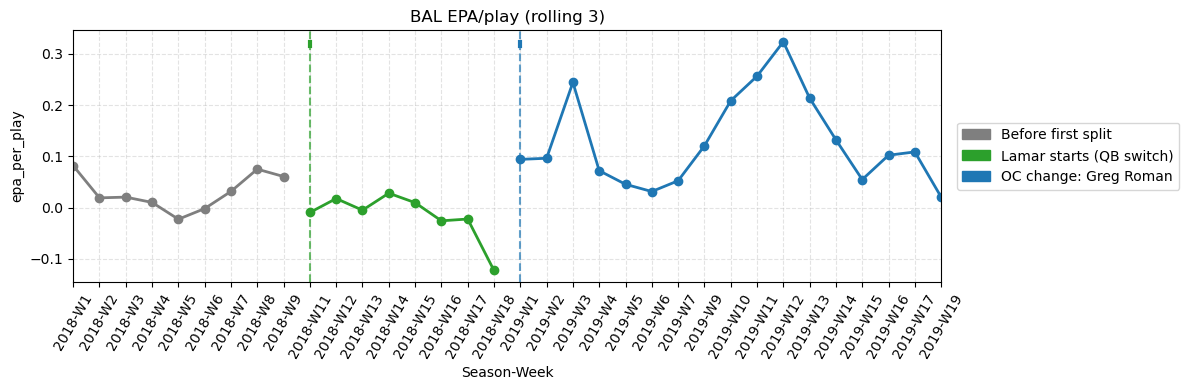

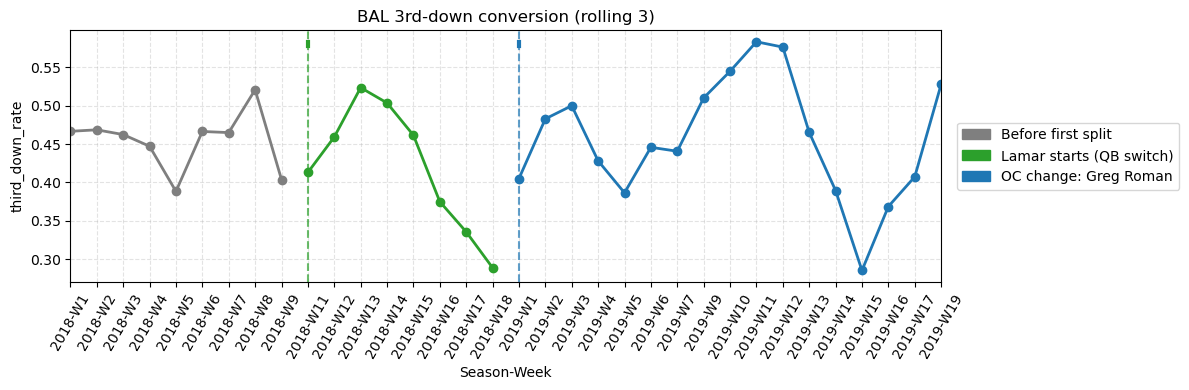

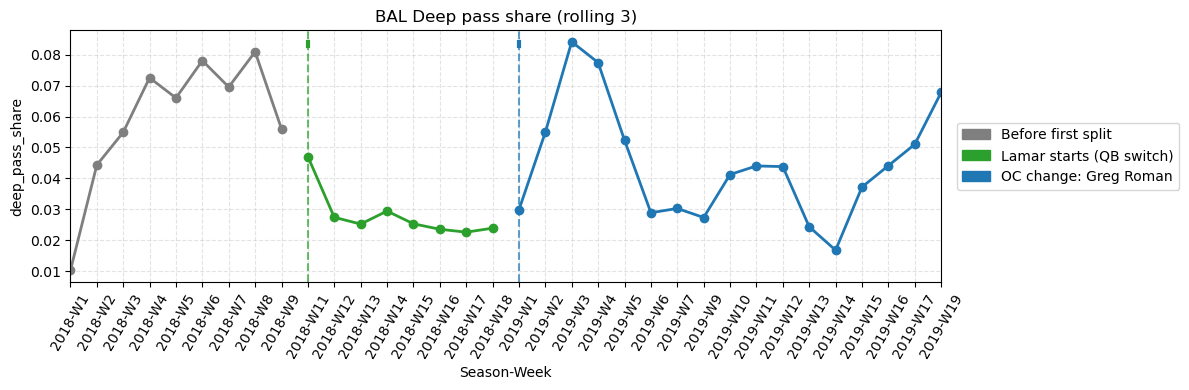

In [35]:
# Example for BAL 2018–2019, metric: epa_per_play
segments_bal = [
    {"season":2018, "week":11, "label":"Lamar starts (QB switch)", "color":"tab:green"},
    {"season":2019, "week":1,  "label":"OC change: Greg Roman",    "color":"tab:blue"},
]

_ = segmented_line_with_side_notes(
    team_week_enriched,
    team="BAL",
    window=(2018, 2019),
    metric="epa_per_play",
    segments=segments_bal,
    title="BAL EPA/play (rolling 3)",
    rolling=3,
    save_as="BAL_2018_2019_epa_segmented.png"
)

# Third down conversion
_ = segmented_line_with_side_notes(
    team_week_enriched, "BAL", (2018, 2019), "third_down_rate",
    segments_bal, title="BAL 3rd-down conversion (rolling 3)", rolling=3
)

# Deep pass share
_ = segmented_line_with_side_notes(
    team_week_enriched, "BAL", (2018, 2019), "deep_pass_share",
    segments_bal, title="BAL Deep pass share (rolling 3)", rolling=3
)


TB 2019–2020

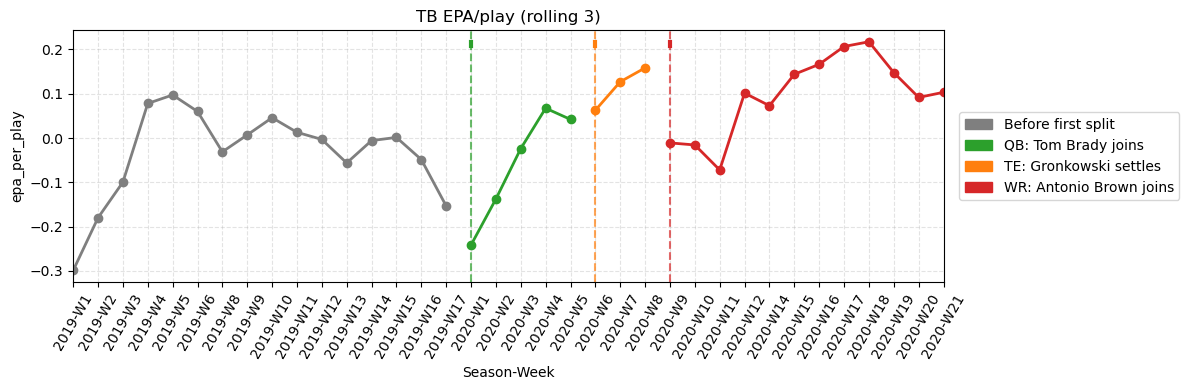

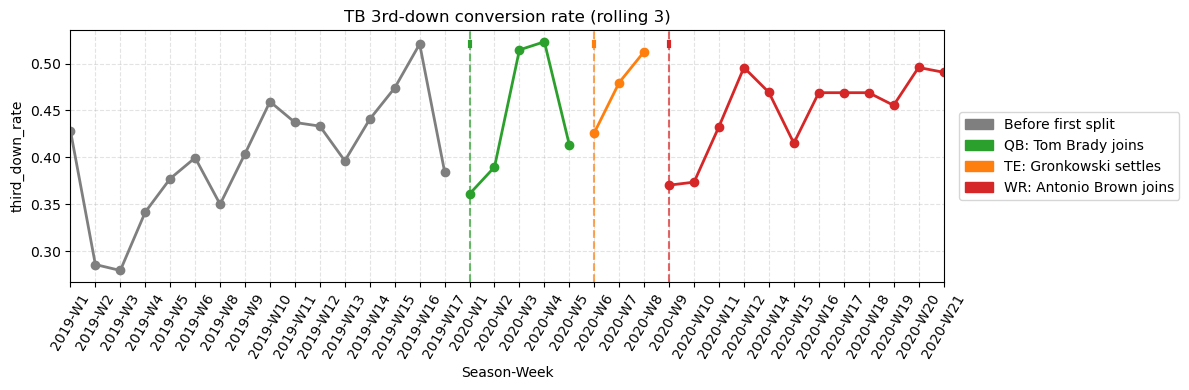

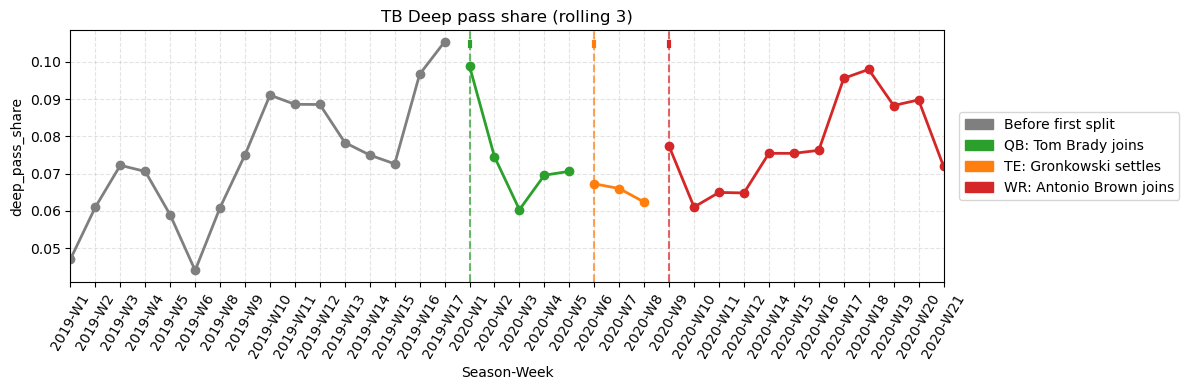

In [36]:
# TB 2019–2020 分割点配置
segments_tb = [
    {"season":2020, "week":1, "label":"QB: Tom Brady joins",     "color":"tab:green"},
    {"season":2020, "week":6, "label":"TE: Gronkowski settles",  "color":"tab:orange"},
    {"season":2020, "week":9, "label":"WR: Antonio Brown joins", "color":"tab:red"},
]

# EPA/play 可视化
_ = segmented_line_with_side_notes(
    team_week_enriched,
    team="TB",
    window=(2019, 2020),
    metric="epa_per_play",
    segments=segments_tb,
    title="TB EPA/play (rolling 3)",
    rolling=3
)

# 第三档成功率
_ = segmented_line_with_side_notes(
    team_week_enriched,
    team="TB",
    window=(2019, 2020),
    metric="third_down_rate",
    segments=segments_tb,
    title="TB 3rd-down conversion rate (rolling 3)",
    rolling=3
)

# 深传占比
_ = segmented_line_with_side_notes(
    team_week_enriched,
    team="TB",
    window=(2019, 2020),
    metric="deep_pass_share",
    segments=segments_tb,
    title="TB Deep pass share (rolling 3)",
    rolling=3
)



SF 2019–2021

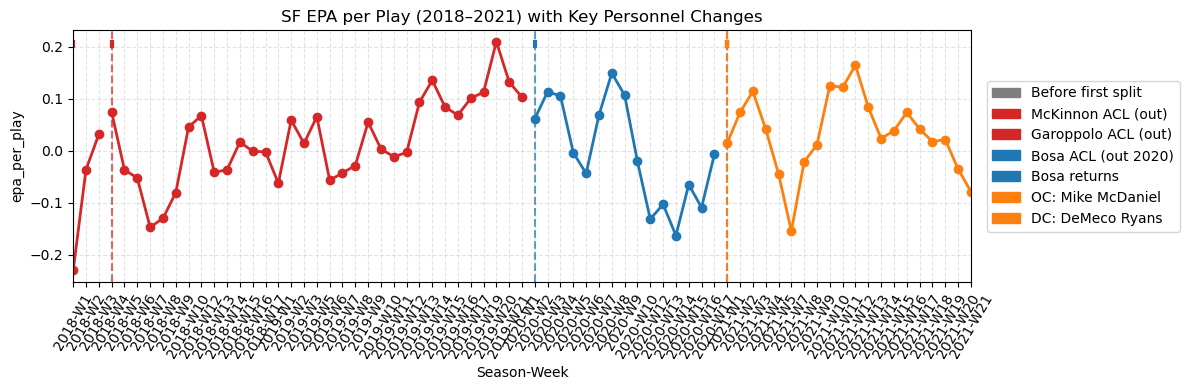

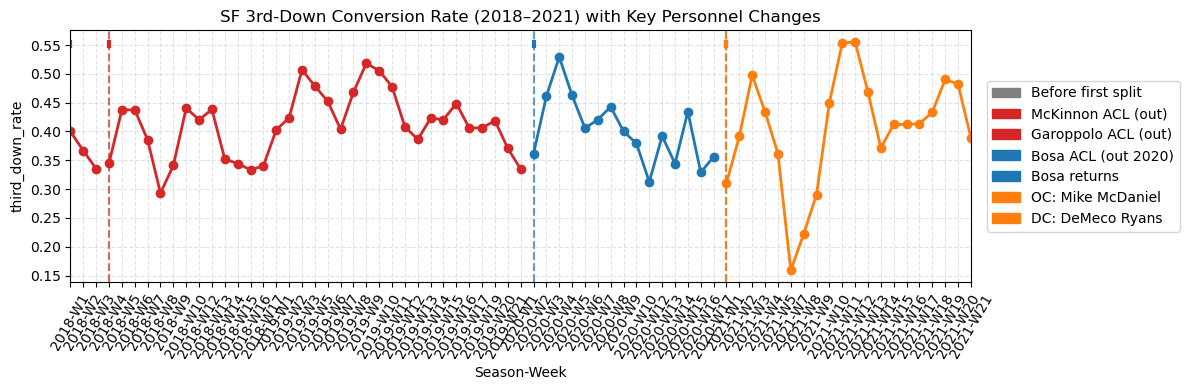

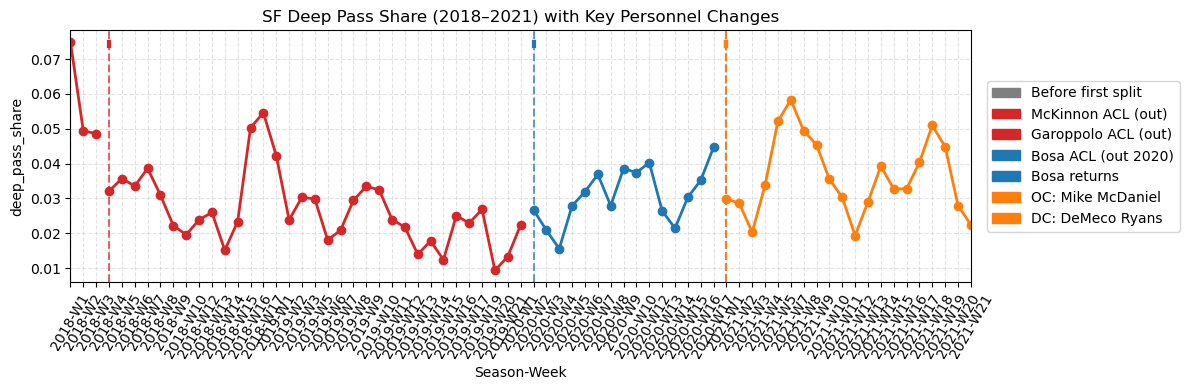

season  week team  plays  pass_rate  rush_rate  rpo_share  \
69     2018     1   SF   80.0   0.525000   0.300000        0.0   
70     2018     2   SF   84.0   0.428571   0.321429        0.0   
71     2018     3   SF   85.0   0.470588   0.329412        0.0   
72     2018     4   SF   79.0   0.544304   0.215190        0.0   
73     2018     5   SF  115.0   0.556522   0.304348        0.0   
..      ...   ...  ...    ...        ...        ...        ...   
135    2021    17   SF   76.0   0.355263   0.473684        0.0   
136    2021    18   SF   87.0   0.402299   0.379310        0.0   
137    2021    19   SF   88.0   0.306818   0.431818        0.0   
138    2021    20   SF   66.0   0.363636   0.454545        0.0   
139    2021    21   SF   68.0   0.455882   0.279412        0.0   

     deep_pass_share  short_pass_share  screen_behind_share  ...  \
69          0.075000          0.137500             0.062500  ...   
70          0.023810          0.154762             0.071429  ...   
71          0.047059          0.164706             0.047059  ...   
72          0.025316          0.240506             0.101266  ...   
73          0.034783          0.295652             0.104348  ...   
..               ...               ...                  ...  ...   
135         0.065789          0.065789             0.039474  ...   
136         0.045977          0.160920             0.068966  ...   
137         0.022727          0.147727             0.056818  ...   
138         0.015152          0.136364             0.075758  ...   
139         0.029412          0.205882             0.132353  ...   

     injured_starter_def_x.1  injured_starter_off_y.1  \
69                         0                        0   
70                         0                        0   
71                         0                        0   
72                         0                        0   
73                         0                        0   
..                       ...                      ...   
135                        0                        0   
136                        0                        0   
137                        0                        0   
138                        0                        0   
139                        0                        0   

     injured_starter_def_y.1  injured_starter_off_x.2  \
69                         0                        0   
70                         0                        0   
71                         0                        0   
72                         0                        0   
73                         0                        0   
..                       ...                      ...   
135                        0                        0   
136                        0                        0   
137                        0                        0   
138                        0                        0   
139                        0                        0   

     injured_starter_def_x.2  injured_starter_off_y.2  \
69                         0                        0   
70                         0                        0   
71                         0                        0   
72                         0                        0   
73                         0                        0   
..                       ...                      ...   
135                        0                        0   
136                        0                        0   
137                        0                        0   
138                        0                        0   
139                        0                        0   

     injured_starter_def_y.2  injured_starter_off  injured_starter_def  \
69                         0                    1                    0   
70                         0                    1                    0   
71                         0                    1                    0   
72                         0                

In [5]:
sf_events = [e for e in EVENTS if e["team"]=="SF"]

# 1) EPA per play
segmented_line_with_side_notes(
    df=team_week_enriched,
    team="SF",
    window=COMPARE_WINDOWS["SF"],      # (2018, 2021)
    metric="epa_per_play",
    segments=sf_events,
    title="SF EPA per Play (2018–2021) with Key Personnel Changes",
    rolling=3,
)

# 2) 第三档成功率（third_down_rate）
segmented_line_with_side_notes(
    df=team_week_enriched,
    team="SF",
    window=COMPARE_WINDOWS["SF"],
    metric="third_down_rate",
    segments=sf_events,
    title="SF 3rd-Down Conversion Rate (2018–2021) with Key Personnel Changes",
    rolling=3,
)

# 3) 深传占比（deep_pass_share）
segmented_line_with_side_notes(
    df=team_week_enriched,
    team="SF",
    window=COMPARE_WINDOWS["SF"],
    metric="deep_pass_share",
    segments=sf_events,
    title="SF Deep Pass Share (2018–2021) with Key Personnel Changes",
    rolling=3,
)



microscopic

In [6]:
# ===== Cell 1: Imports & Config =====
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- Your local PBP cache base dir ----
# Expect files like play_by_play_2018.csv or .csv.gz inside this dir (or a sub-dir).
BASE_DIR = r"D:\Final\nfl\2023\pbp_official_cache"

YEARS = [2018, 2019, 2020, 2021]
TEAMS_OF_INTEREST = ["BAL", "TB", "SF"]

# Compare windows (macro context)
COMPARE_WINDOWS = {
    "BAL": (2018, 2019),
    "TB":  (2019, 2020),
    "SF":  (2018, 2021),  # SF uses 2018–2021 span
}

# Personnel/coach events (common, editable)
EVENTS = [
    # Ravens
    {"team":"BAL","season":2018,"week":11,"label":"Lamar starts (QB switch)", "side":"OFF"},
    {"team":"BAL","season":2019,"week":1, "label":"OC: Greg Roman",           "side":"COACH"},
    {"team":"BAL","season":2019,"week":1, "label":"+Mark Ingram (RB)",        "side":"OFF"},
    # Buccaneers
    {"team":"TB","season":2020,"week":1,  "label":"QB: Tom Brady",            "side":"OFF"},
    {"team":"TB","season":2020,"week":1,  "label":"+Gronkowski (TE)",         "side":"OFF"},
    {"team":"TB","season":2020,"week":9,  "label":"+Antonio Brown (WR)",      "side":"OFF"},
    {"team":"TB","season":2020,"week":1,  "label":"RT: Tristan Wirfs rookie", "side":"OFF"},
    {"team":"TB","season":2019,"week":1,  "label":"DC: Todd Bowles",          "side":"DEF"},
    # 49ers
    {"team":"SF","season":2018,"week":1,  "label":"McKinnon ACL (out)",       "side":"OFF"},
    {"team":"SF","season":2018,"week":4,  "label":"Garoppolo ACL (out)",      "side":"OFF"},
    {"team":"SF","season":2020,"week":2,  "label":"Bosa ACL (out 2020)",      "side":"DEF"},
    {"team":"SF","season":2021,"week":1,  "label":"Bosa returns",             "side":"DEF"},
    {"team":"SF","season":2021,"week":1,  "label":"OC: Mike McDaniel",        "side":"COACH"},
    {"team":"SF","season":2021,"week":1,  "label":"DC: DeMeco Ryans",         "side":"COACH"},
]

# Side -> color map for event segments
SIDE_COLOR = {"OFF":"tab:red", "DEF":"tab:blue", "COACH":"tab:orange"}
for ev in EVENTS:
    ev["color"] = SIDE_COLOR.get(ev.get("side",""), "tab:gray")

plt.rcParams["figure.dpi"] = 120


In [7]:
# ===== Cell 2: Load PBP (robust resolver) =====
def find_pbp_file(base_dir, year):
    """
    Try common locations:
    - base_dir/play_by_play_{year}.csv[.gz]
    - base_dir/**/play_by_play_{year}.csv[.gz]
    """
    candidates = []
    for ext in (".csv", ".csv.gz"):
        p = os.path.join(base_dir, f"play_by_play_{year}{ext}")
        candidates.append(p)
        # also search recursively
        candidates.extend(glob.glob(os.path.join(base_dir, "**", f"play_by_play_{year}{ext}"), recursive=True))
    for c in candidates:
        if os.path.exists(c):
            return c
    return None

def load_pbp_year(year):
    path = find_pbp_file(BASE_DIR, year)
    if not path:
        raise FileNotFoundError(f"PBP for {year} not found under {BASE_DIR}")
    print(f"[load] {year}: {path}")
    df = pd.read_csv(path, low_memory=False)
    df["season"] = year  # enforce
    return df

# Load and concatenate
pbp_list = [load_pbp_year(y) for y in YEARS]
pbp_raw = pd.concat(pbp_list, ignore_index=True)
print("[shape] PBP all:", pbp_raw.shape)

# Basic standardization of common columns (create if missing)
need_cols = [
    "game_id","play_id","posteam","defteam","season","week","play_type",
    "pass","rush","qb_scramble","sack","interception","air_yards","pass_length","pass_location",
    "passer_id","passer","receiver","rusher","epa","success",
    "qb_hit","pressure"
]
for c in need_cols:
    if c not in pbp_raw.columns:
        pbp_raw[c] = np.nan

# Coerce numeric flags
for c in ["pass","rush","qb_scramble","sack","interception","success","qb_hit","pressure","air_yards","epa"]:
    if c in pbp_raw.columns:
        pbp_raw[c] = pd.to_numeric(pbp_raw[c], errors="coerce")
pbp_raw["week"] = pd.to_numeric(pbp_raw["week"], errors="coerce")


[load] 2018: D:\Final\nfl\2023\pbp_official_cache\data\play_by_play_2018.csv
[load] 2019: D:\Final\nfl\2023\pbp_official_cache\data\play_by_play_2019.csv
[load] 2020: D:\Final\nfl\2023\pbp_official_cache\data\play_by_play_2020.csv
[load] 2021: D:\Final\nfl\2023\pbp_official_cache\data\play_by_play_2021.csv
[shape] PBP all: (195134, 372)


C:\Users\PuhanWang\AppData\Local\Temp\ipykernel_27656\3815824404.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp_raw[c] = np.nan


In [15]:
# ===== Cell 3: Derive micro features on plays =====

df = pbp_raw.copy()

# Define dropbacks (pass attempts + sacks + scrambles)
df["is_dropback"] = (
    (df["pass"]==1) | (df["sack"]==1) | (df["qb_scramble"]==1)
).astype(int)

# Deep/Mid/Short buckets from air_yards (fallback to pass_length if needed)
def bucket_from_air(ay):
    if pd.isna(ay): 
        return np.nan
    try:
        ay = float(ay)
    except:
        return np.nan
    if ay >= 20: return "deep"
    if ay >= 10: return "mid"
    if ay >= 0:  return "short"
    # negative air_yards (behind LOS) count as short
    return "short"

df["depth_bucket"] = df["air_yards"].apply(bucket_from_air)
# Fallback using pass_length if no air_yards info
mask_no_bucket = df["depth_bucket"].isna() & df["pass_length"].notna()
df.loc[mask_no_bucket, "depth_bucket"] = df.loc[mask_no_bucket, "pass_length"].str.lower().map({"deep":"deep","short":"short"})

# QB rush (prefer qb_scramble; also consider designed QB rush if rusher == passer)
df["qb_rush_flag"] = 0
df.loc[df["qb_scramble"]==1, "qb_rush_flag"] = 1
same_name = (df["rusher"].astype(str).str.lower() == df["passer"].astype(str).str.lower())
df.loc[(df["rush"]==1) & same_name, "qb_rush_flag"] = 1

# Pressure proxy: any available of pressure or qb_hit or sack
df["pressure_flag"] = 0
for col in ["pressure","qb_hit","sack"]:
    if col in df.columns:
        df.loc[pd.to_numeric(df[col], errors="coerce")==1, "pressure_flag"] = 1


for c in ["down", "ydstogo", "yards_gained", "first_down", "third_down_converted"]:
    if c not in df.columns:
        df[c] = np.nan

df["down"] = pd.to_numeric(df["down"], errors="coerce")
df["ydstogo"] = pd.to_numeric(df["ydstogo"], errors="coerce")
df["yards_gained"] = pd.to_numeric(df["yards_gained"], errors="coerce")

# attempt: down == 3
df["third_down_attempt"] = (df["down"] == 3).astype(int)

# conversion logic: prefer explicit flags; otherwise yards_gained >= ydstogo
third_conv_explicit = pd.to_numeric(df["third_down_converted"], errors="coerce") == 1
first_down_explicit = pd.to_numeric(df["first_down"], errors="coerce") == 1
gain_meets_to_go = (df["yards_gained"] >= df["ydstogo"])

df["third_down_success"] = 0
df.loc[df["third_down_attempt"] == 1, "third_down_success"] = (
    third_conv_explicit | first_down_explicit | gain_meets_to_go
).astype(int)

# Red-zone, if yardline info exists (optional)
# if 'yardline_100' in df.columns:
#     df["in_red_zone"] = (df["yardline_100"] <= 20).astype(int)


In [16]:
# ===== Cell 4 (fixed): Aggregate micro metrics to team-week =====

def safe_mean(s):
    s = pd.to_numeric(s, errors="coerce")
    return s.mean()

def agg_offense(sub):
    dd = {}
    drop = sub["is_dropback"].sum()
    passes = (sub["pass"]==1).sum()
    rushes = (sub["rush"]==1).sum()
    dd["dropbacks"] = drop
    dd["passes"] = passes
    dd["rushes"] = rushes

    dd["epa_per_play"] = pd.to_numeric(sub["epa"], errors="coerce").mean()
    dd["success_rate"] = pd.to_numeric(sub["success"], errors="coerce").mean()

    # pocket protection
    dd["sack_rate"] = (sub["sack"].sum()/drop) if drop>0 else np.nan
    dd["pressure_rate"] = (sub["pressure_flag"].sum()/drop) if drop>0 else np.nan

    # pass depth shares (on passes only)
    pass_sub = sub[sub["pass"]==1]
    pcount = len(pass_sub)
    for b in ["short","mid","deep"]:
        dd[f"{b}_pass_share"] = ((pass_sub["depth_bucket"]==b).sum()/pcount) if pcount>0 else np.nan
        dd[f"{b}_pass_epa"]   = pd.to_numeric(pass_sub.loc[pass_sub["depth_bucket"]==b, "epa"], errors="coerce").mean()

    # QB rushing
    qb_rushes = sub["qb_rush_flag"].sum()
    dd["qb_rush_rate_among_rush"] = (qb_rushes/rushes) if rushes>0 else np.nan
    dd["qb_rush_epa"] = pd.to_numeric(sub.loc[sub["qb_rush_flag"]==1, "epa"], errors="coerce").mean()

    # 3rd down conversion rate (offense)
    att3 = sub["third_down_attempt"].sum()
    suc3 = sub["third_down_success"].sum()
    dd["third_down_attempts"] = att3
    dd["third_down_conversions"] = suc3
    dd["third_down_rate"] = (suc3/att3) if att3>0 else np.nan

    return pd.Series(dd)


def agg_defense(sub):
    dd = {}
    drop = sub["is_dropback"].sum()
    dd["def_interceptions"] = sub["interception"].sum()
    dd["def_sacks"] = sub["sack"].sum()
    dd["def_interception_rate"] = (sub["interception"].sum()/drop) if drop>0 else np.nan
    dd["def_sack_rate"] = (sub["sack"].sum()/drop) if drop>0 else np.nan
    return pd.Series(dd)

# --- Offense (posteam) ---
off_agg = (
    df.groupby(["posteam","season","week"], dropna=False)
      .apply(agg_offense)
      .reset_index()
      .rename(columns={"posteam":"team"})
)

# --- Defense (defteam) ---
def_agg = (
    df.groupby(["defteam","season","week"], dropna=False)
      .apply(agg_defense)
      .reset_index()
      .rename(columns={"defteam":"team"})
)

# --- 防止重复列名（极端情况下外部代码可能已存在 'team' 等重复列）---
off_agg = off_agg.loc[:, ~off_agg.columns.duplicated()]
def_agg = def_agg.loc[:, ~def_agg.columns.duplicated()]

# --- 合并 offense + defense 为 team-week 微观表 ---
team_week_micro = pd.merge(
    off_agg, def_agg,
    on=["team","season","week"],
    how="outer",
    validate="one_to_one"  # 若报错，说明同一 team-season-week 在某一侧有重复行
)

# （可选）只保留感兴趣球队
team_week_micro = team_week_micro[team_week_micro["team"].isin(TEAMS_OF_INTEREST)].copy()
team_week_micro = team_week_micro.sort_values(["team","season","week"]).reset_index(drop=True)

print("[shape] team_week_micro:", team_week_micro.shape)
team_week_micro.to_csv("team_week_micro_metrics.csv", index=False)
print("[save] team_week_micro_metrics.csv")



[shape] team_week_micro: (211, 25)
[save] team_week_micro_metrics.csv


In [17]:
# ===== Cell 5: Segmented plot helper =====

def _index_map(sub):
    return {(int(s), int(w)): i for i,(s,w) in enumerate(zip(sub["season"], sub["week"]))}

def _find_idx(idx_map, season, week):
    return idx_map.get((int(season), int(week)), None)

def segmented_line_with_side_notes(df_tw, team, window, metric, events, title=None, rolling=3, save_as=None):
    start_season, end_season = window
    sub = df_tw[(df_tw["team"]==team) & (df_tw["season"]>=start_season) & (df_tw["season"]<=end_season)].copy()
    sub = sub.sort_values(["season","week"])
    if metric not in sub.columns:
        sub[metric] = np.nan

    sub["sw"] = [f"{int(s)}-W{int(w)}" for s,w in zip(sub["season"], sub["week"])]
    x = np.arange(len(sub))
    y = pd.to_numeric(sub[metric], errors="coerce")
    if rolling and rolling>1:
        y = y.rolling(rolling, min_periods=1).mean()

    idx_map = _index_map(sub)
    segs = sorted([e for e in events if e["team"]==team and start_season<=e["season"]<=end_season],
                  key=lambda d: (d["season"], d["week"]))
    cut_idxs = []
    for seg in segs:
        i = _find_idx(idx_map, seg["season"], seg["week"])
        if i is not None:
            cut_idxs.append((i, seg))

    default_color = "tab:gray"
    ranges = []
    prev = 0
    prev_color = default_color
    for (i, seg) in cut_idxs:
        if i > prev:
            ranges.append((prev, i, prev_color))
        prev = i
        prev_color = seg.get("color", "tab:blue")
    ranges.append((prev, len(sub), prev_color))

    fig, ax = plt.subplots(figsize=(12,4))
    for a,b,color in ranges:
        ax.plot(x[a:b], y.iloc[a:b], marker="o", linewidth=2, color=color)

    ymin = np.nanmin(y.values) if np.isfinite(y.values).any() else 0.0
    ymax = np.nanmax(y.values) if np.isfinite(y.values).any() else 0.0
    height = ymax - ymin if ymax>ymin else 1.0
    for (i, seg) in cut_idxs:
        ax.axvline(i, linestyle="--", color=seg.get("color","tab:blue"), alpha=0.7)
        ax.plot([i,i],[ymax, ymax-0.02*height], color=seg.get("color","tab:blue"), linewidth=3)

    ax.set_title(title or f"{team} {metric} (rolling {rolling})")
    ax.set_ylabel(metric)
    ax.set_xlabel("Season-Week")
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.set_xlim(0, len(sub)-1)
    ax.set_xticks(x)
    ax.set_xticklabels(sub["sw"], rotation=60)

    bullets = [mpatches.Patch(color="tab:gray")]
    labels  = ["Before first split"]
    for seg in segs:
        bullets.append(mpatches.Patch(color=seg.get("color","tab:blue")))
        labels.append(seg["label"])
    ax.legend(bullets, labels, loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True)

    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, dpi=150, bbox_inches="tight")
    plt.show()
    return sub


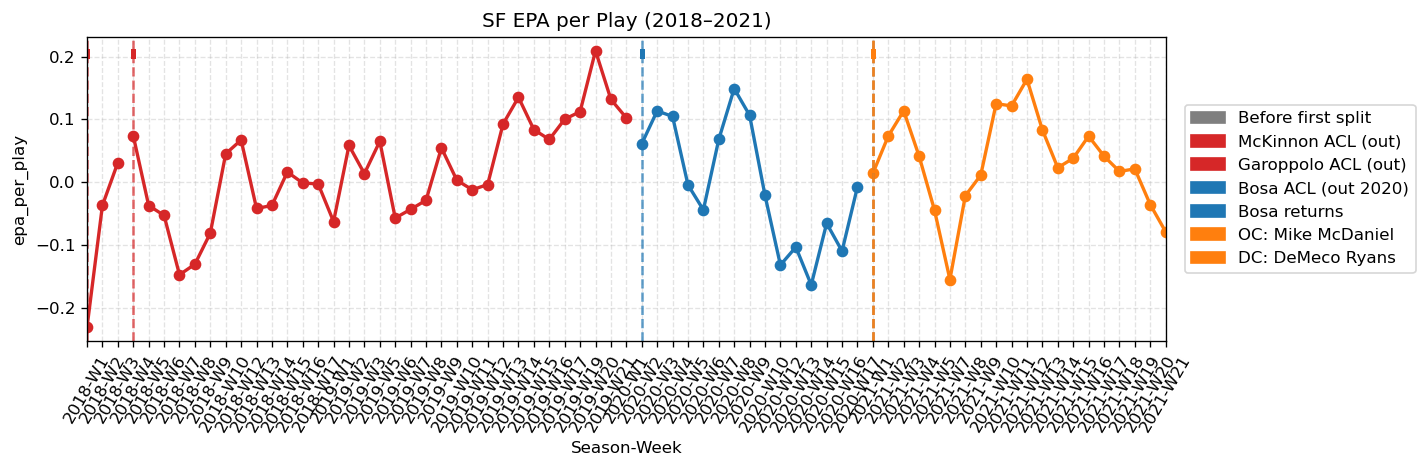

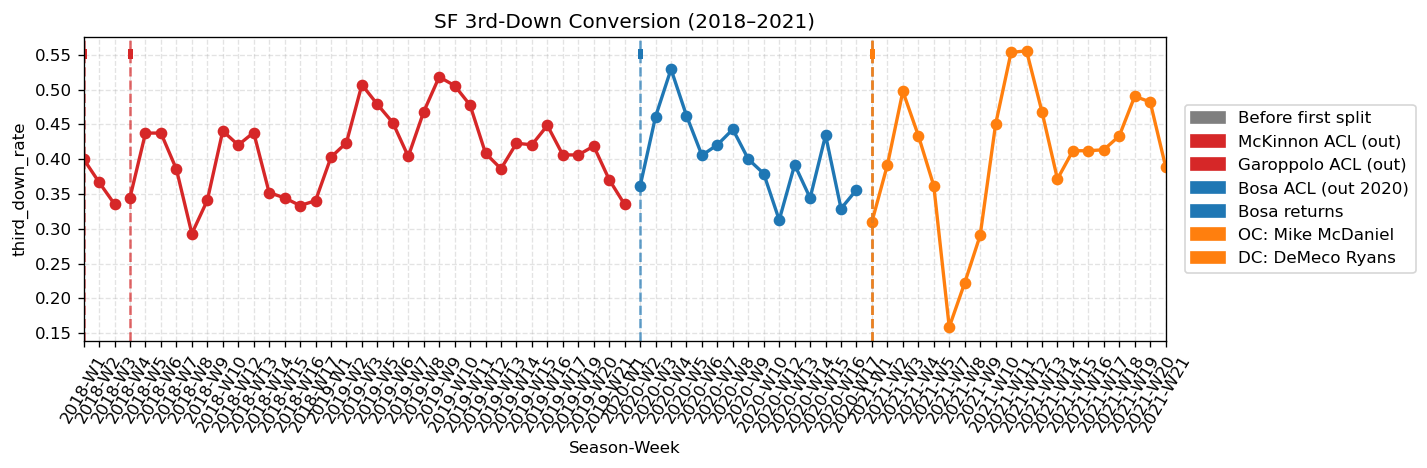

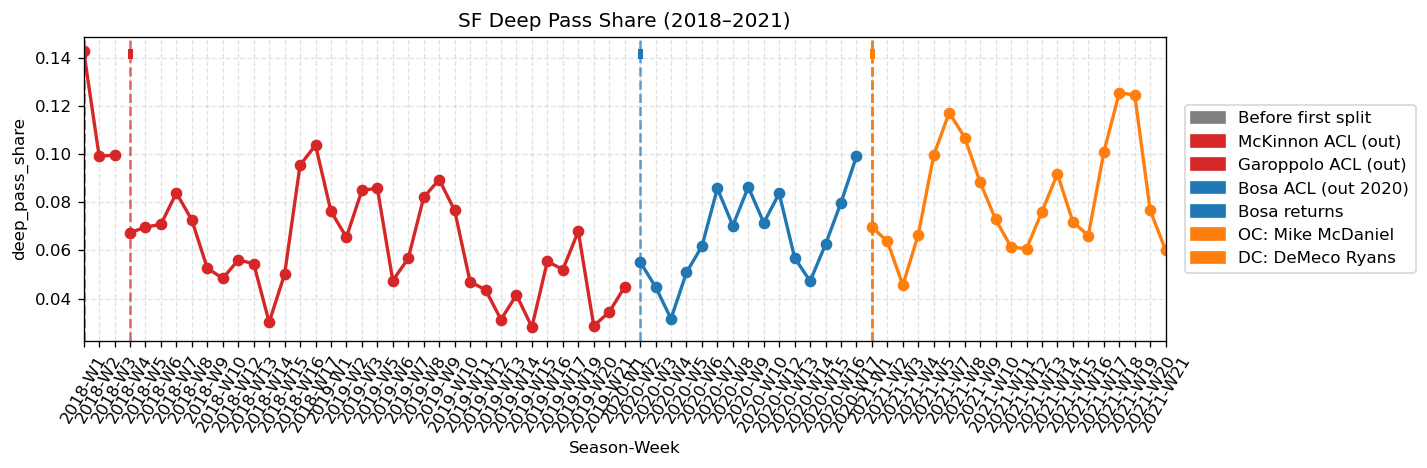

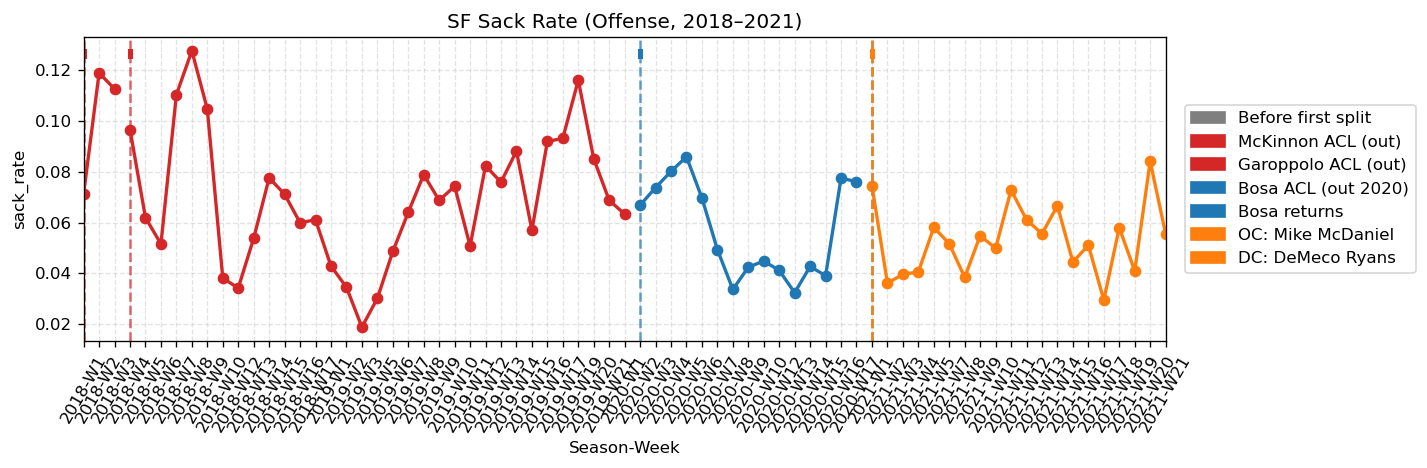

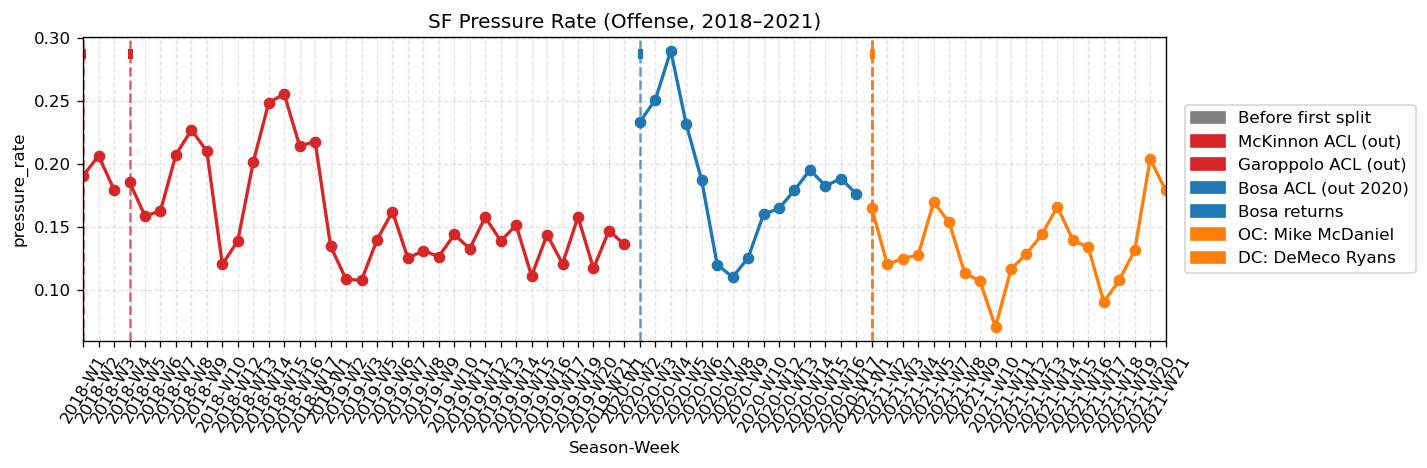

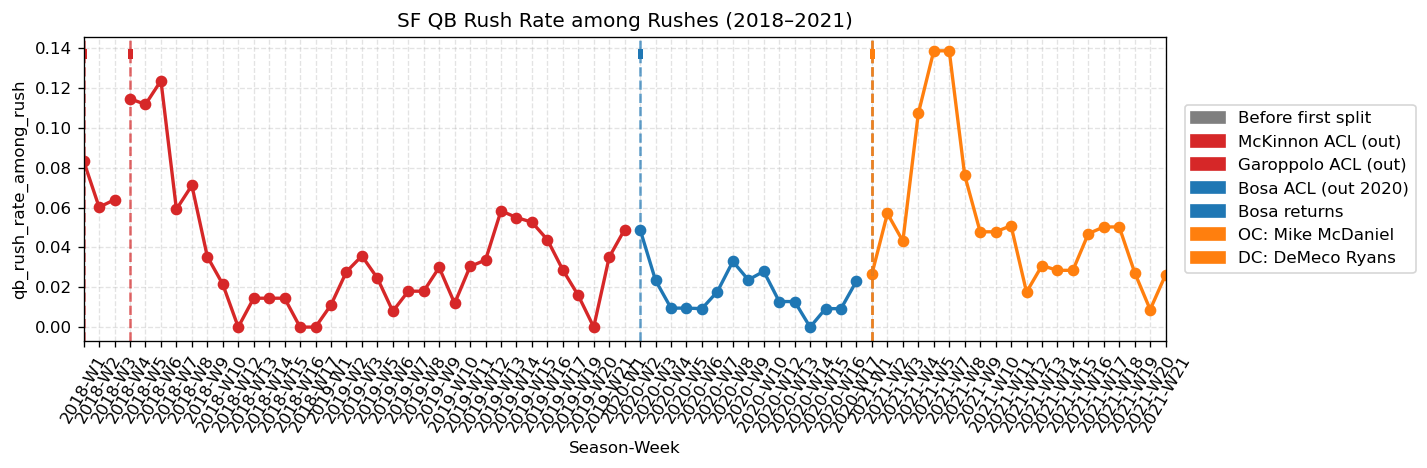

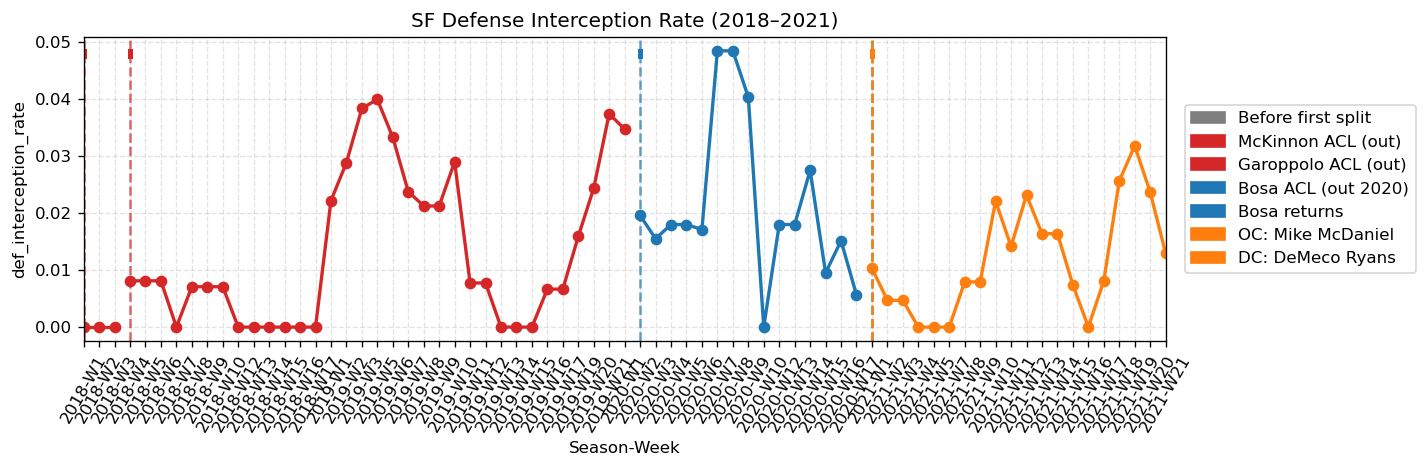

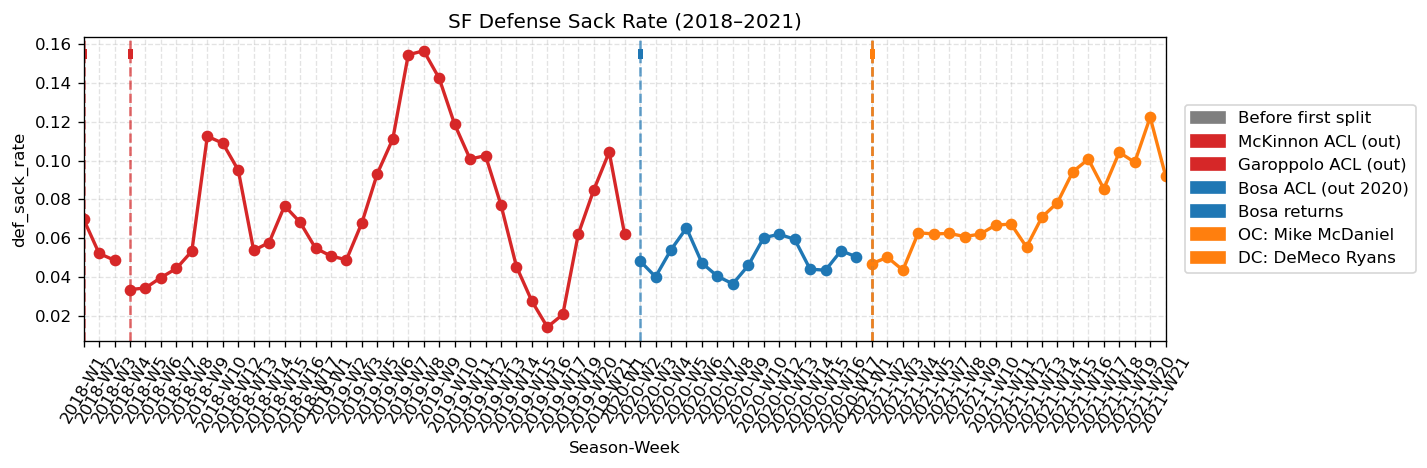

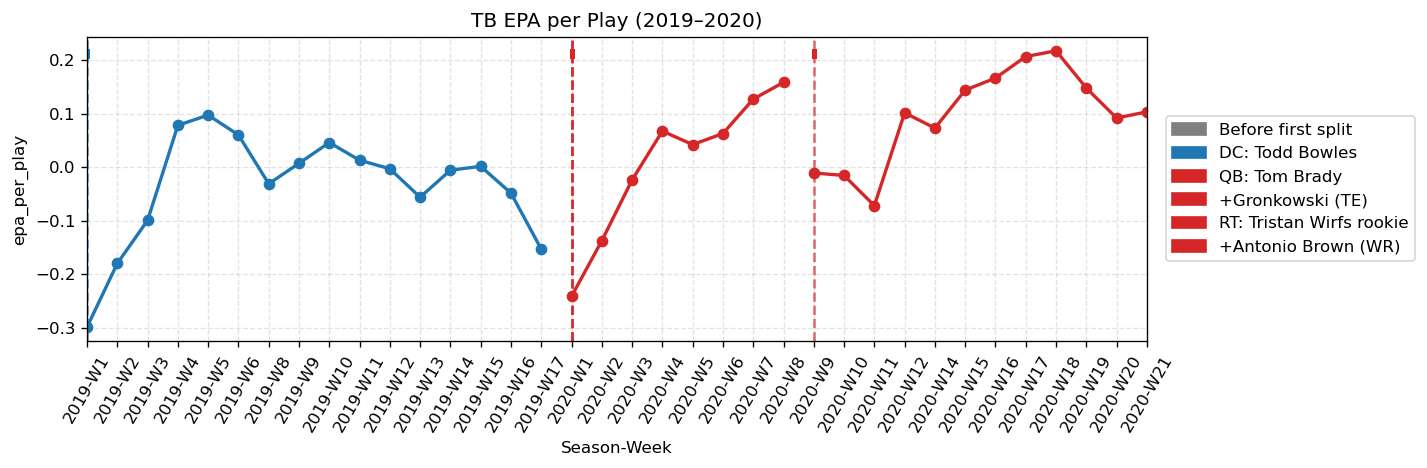

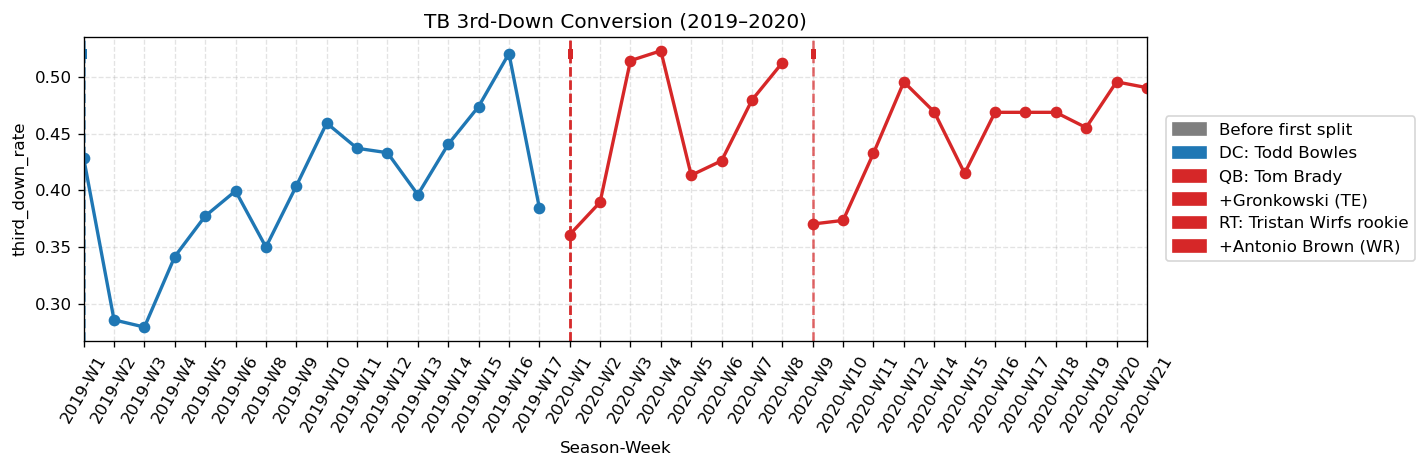

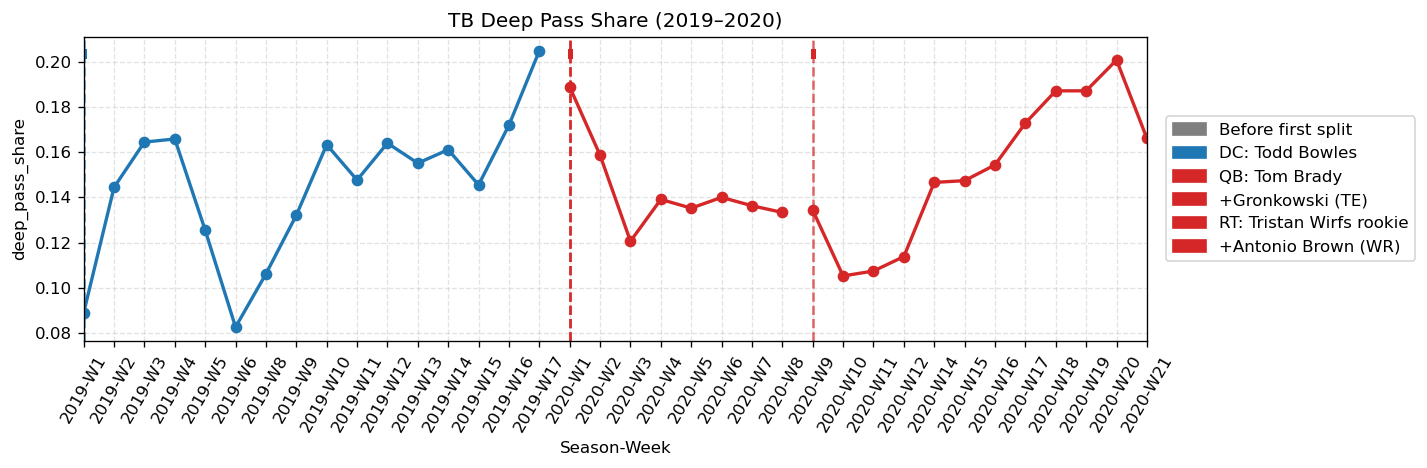

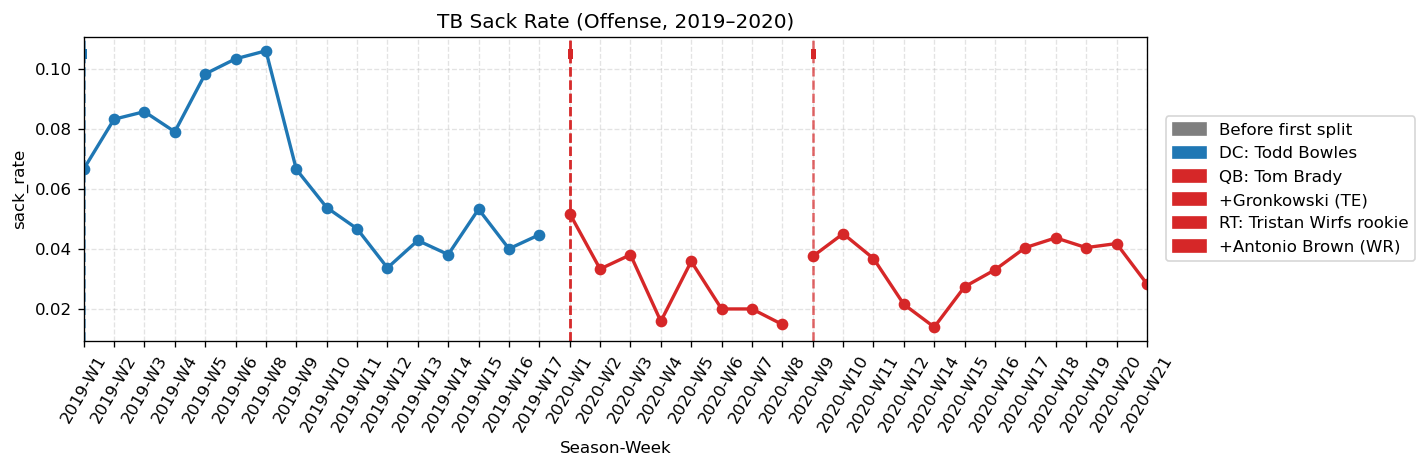

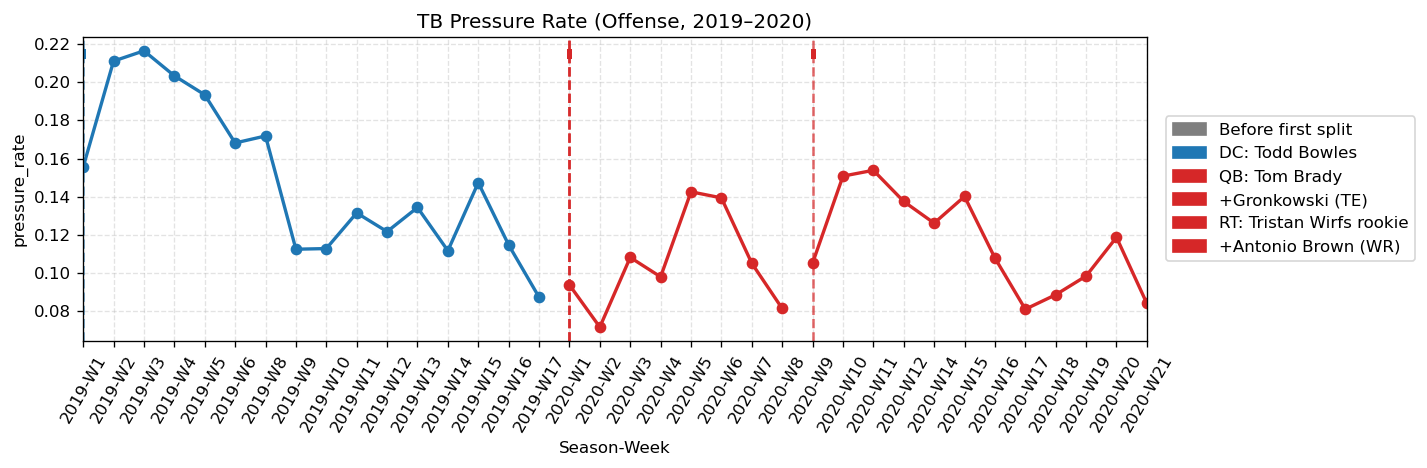

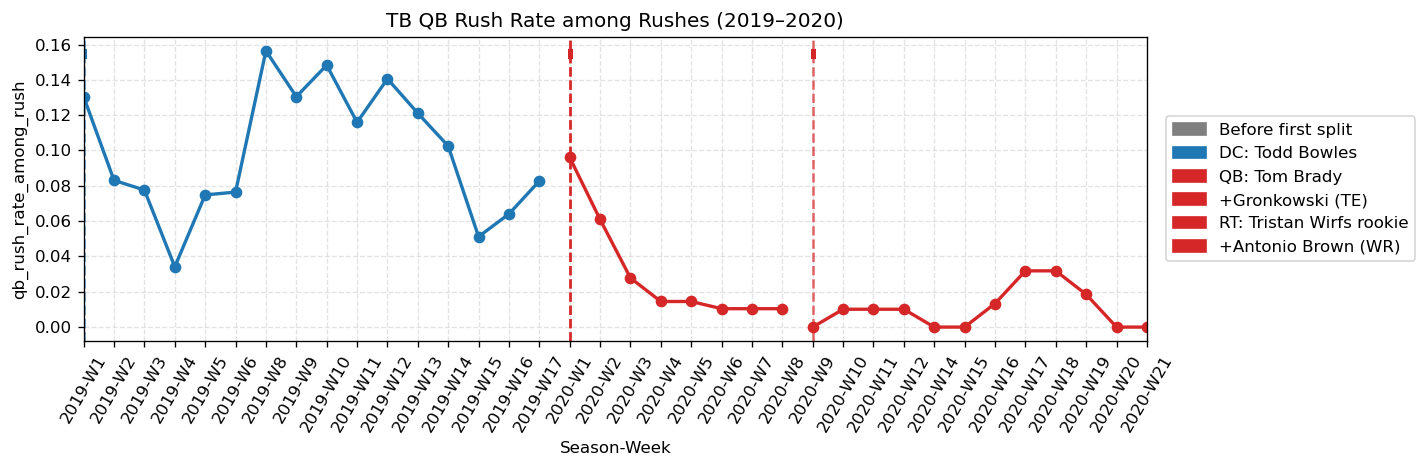

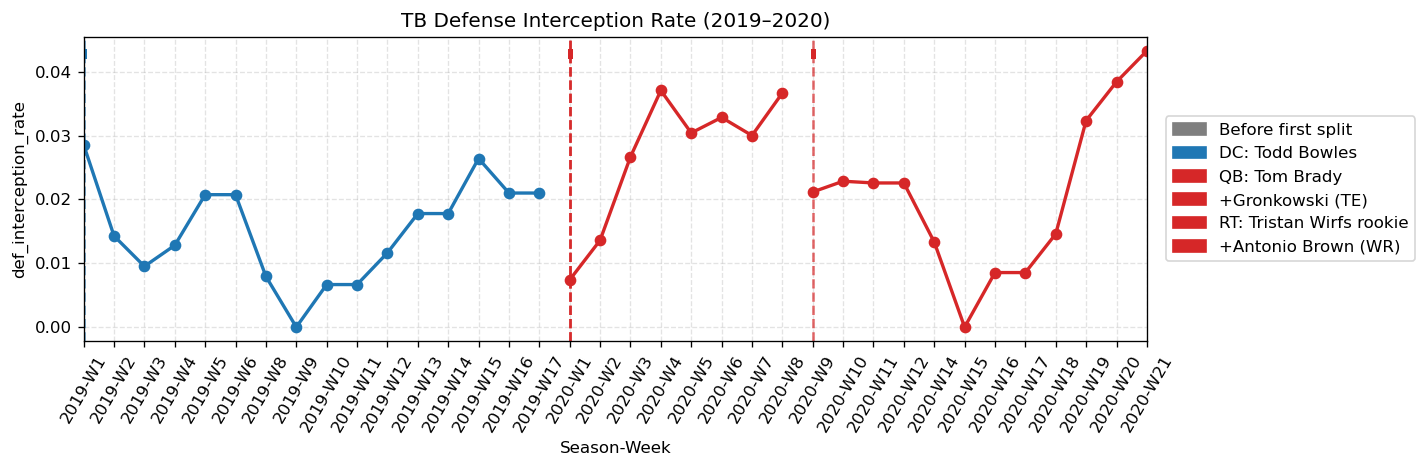

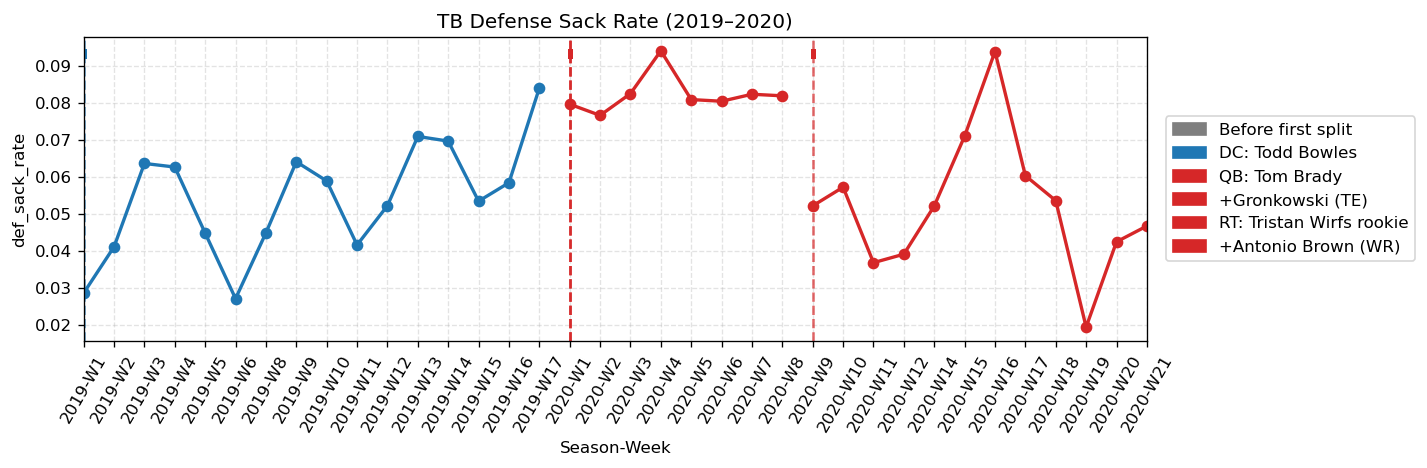

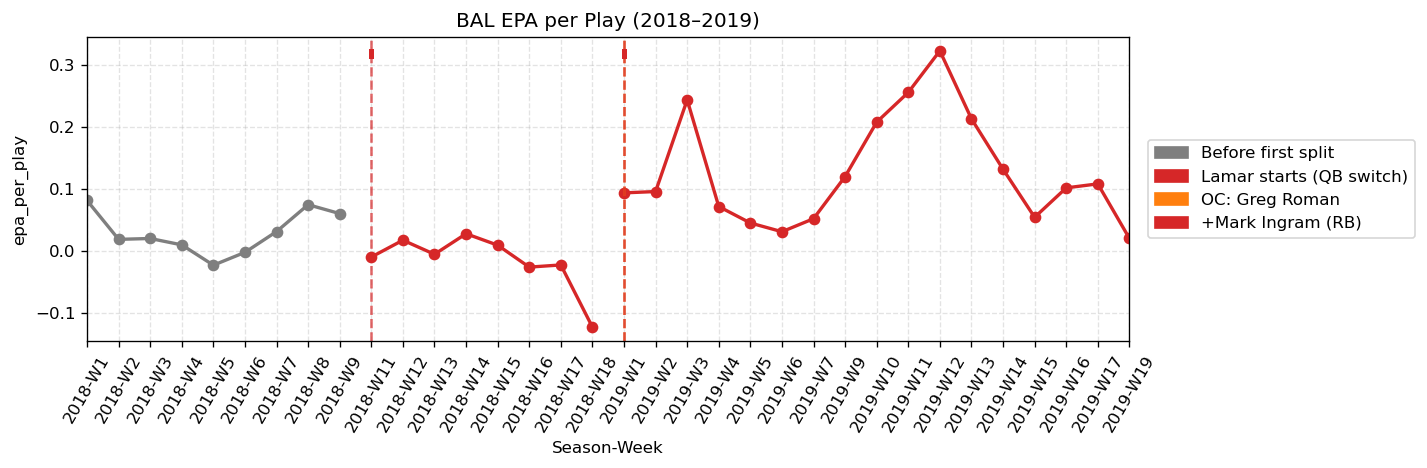

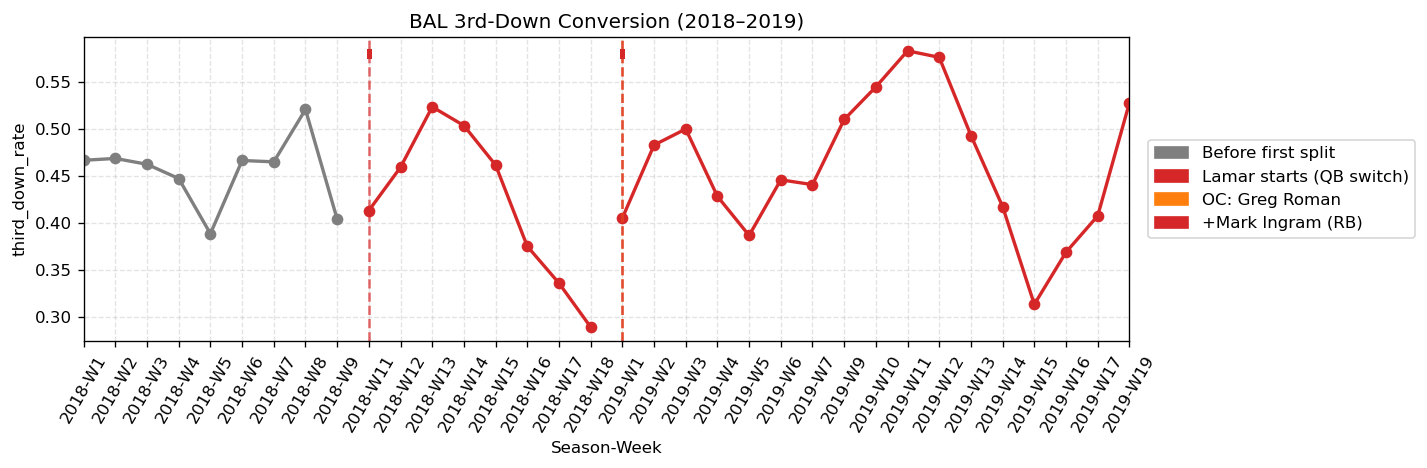

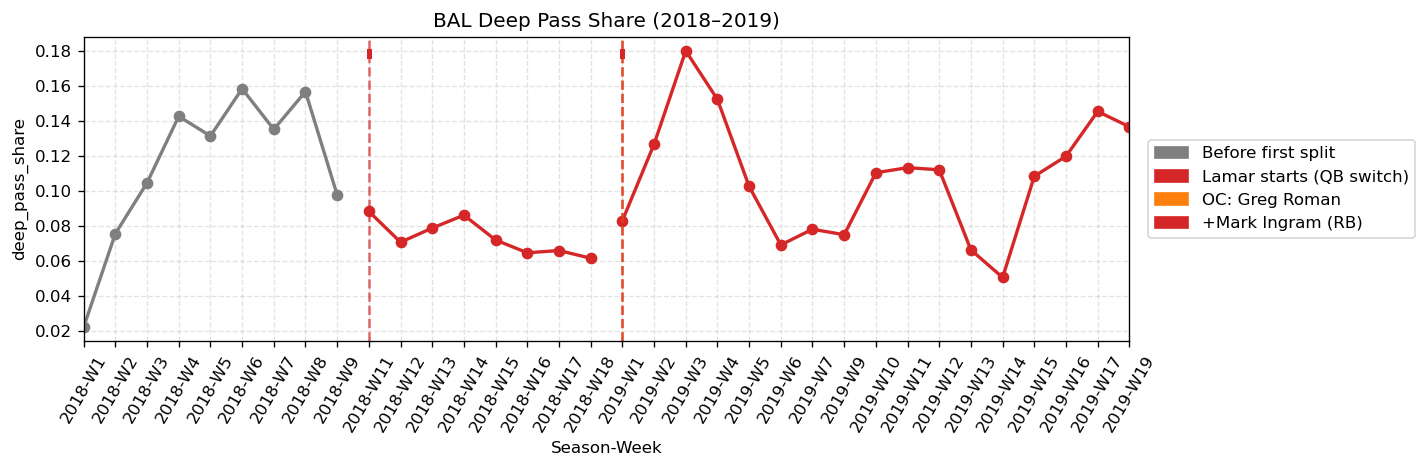

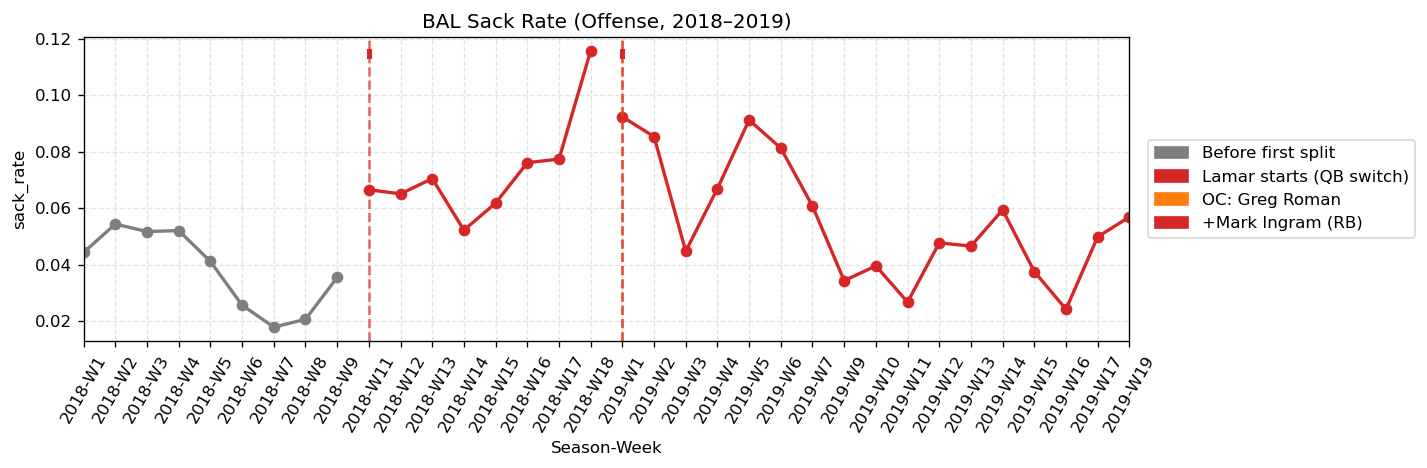

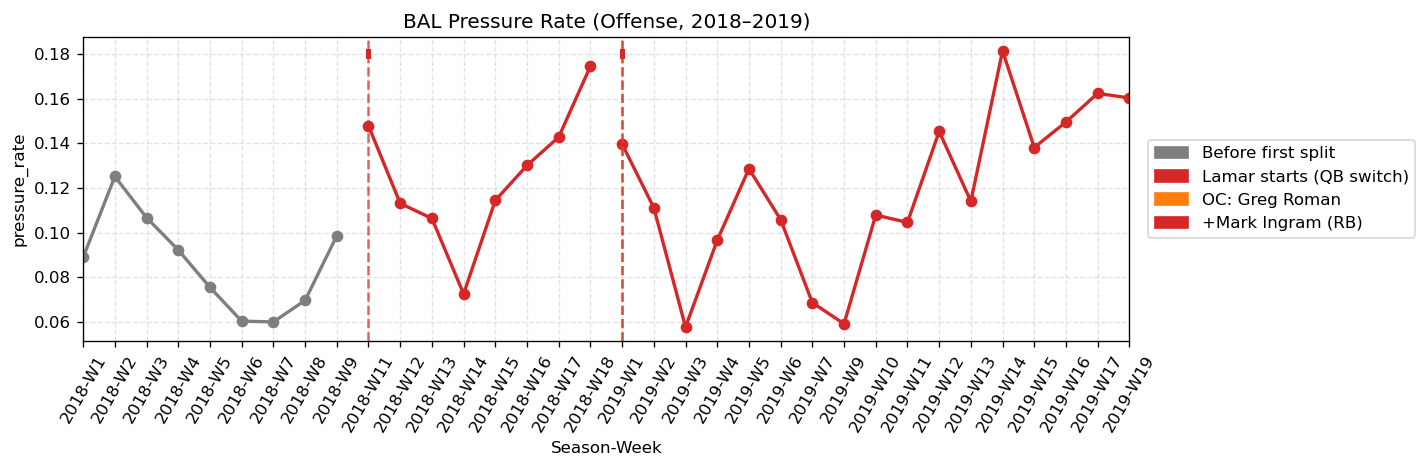

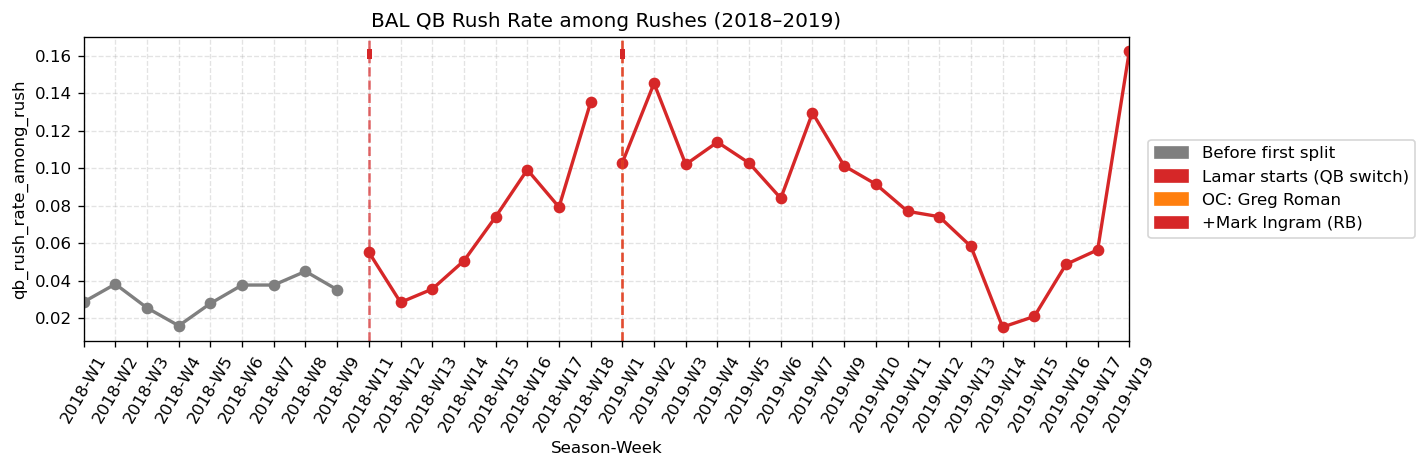

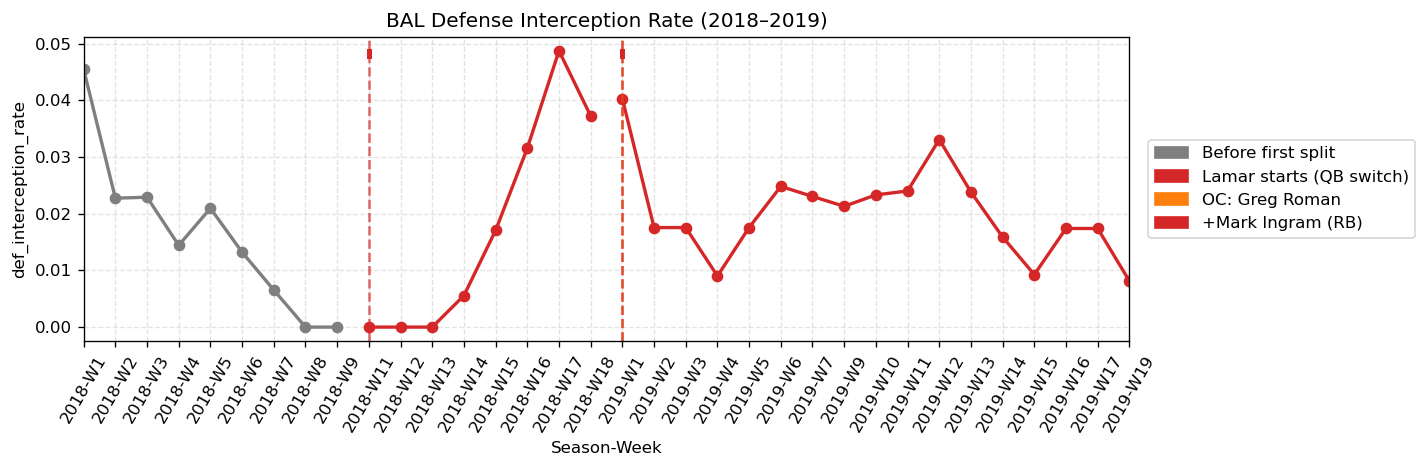

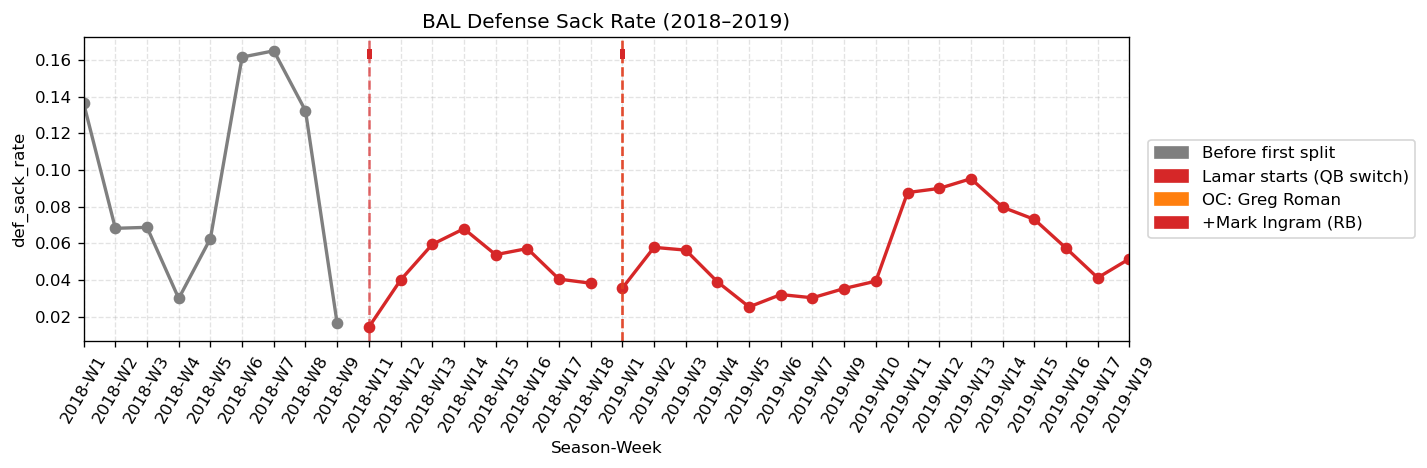

In [18]:
# ===== Cell 6: Example segmented charts =====

# Choose which metrics to visualize (you can add more)
METRICS_SF = [
    ("epa_per_play",        "SF EPA per Play (2018–2021)"),
    ("third_down_rate",     "SF 3rd-Down Conversion (2018–2021)"),
    ("deep_pass_share",     "SF Deep Pass Share (2018–2021)"),
    ("sack_rate",           "SF Sack Rate (Offense, 2018–2021)"),
    ("pressure_rate",       "SF Pressure Rate (Offense, 2018–2021)"),
    ("qb_rush_rate_among_rush", "SF QB Rush Rate among Rushes (2018–2021)"),
    ("def_interception_rate","SF Defense Interception Rate (2018–2021)"),
    ("def_sack_rate",       "SF Defense Sack Rate (2018–2021)"),
]

for metric, title in METRICS_SF:
    segmented_line_with_side_notes(
        df_tw=team_week_micro,
        team="SF",
        window=COMPARE_WINDOWS["SF"],
        metric=metric,
        events=EVENTS,
        title=title,
        rolling=3,
        save_as=None  # or f"sf_{metric}.png"
    )

# (Optional) TB 2019–2020
METRICS_TB = [
    ("epa_per_play","TB EPA per Play (2019–2020)"),
    ("third_down_rate","TB 3rd-Down Conversion (2019–2020)"),
    ("deep_pass_share","TB Deep Pass Share (2019–2020)"),
    ("sack_rate","TB Sack Rate (Offense, 2019–2020)"),
    ("pressure_rate","TB Pressure Rate (Offense, 2019–2020)"),
    ("qb_rush_rate_among_rush","TB QB Rush Rate among Rushes (2019–2020)"),
    ("def_interception_rate","TB Defense Interception Rate (2019–2020)"),
    ("def_sack_rate","TB Defense Sack Rate (2019–2020)"),
]
for metric, title in METRICS_TB:
    segmented_line_with_side_notes(team_week_micro, "TB", COMPARE_WINDOWS["TB"], metric, EVENTS, title, 3, None)

# (Optional) BAL 2018–2019
METRICS_BAL = [
    ("epa_per_play","BAL EPA per Play (2018–2019)"),
    ("third_down_rate","BAL 3rd-Down Conversion (2018–2019)"),
    ("deep_pass_share","BAL Deep Pass Share (2018–2019)"),
    ("sack_rate","BAL Sack Rate (Offense, 2018–2019)"),
    ("pressure_rate","BAL Pressure Rate (Offense, 2018–2019)"),
    ("qb_rush_rate_among_rush","BAL QB Rush Rate among Rushes (2018–2019)"),
    ("def_interception_rate","BAL Defense Interception Rate (2018–2019)"),
    ("def_sack_rate","BAL Defense Sack Rate (2018–2019)"),
]
for metric, title in METRICS_BAL:
    segmented_line_with_side_notes(team_week_micro, "BAL", COMPARE_WINDOWS["BAL"], metric, EVENTS, title, 3, None)


In [19]:
# ===== Cell 7: Before-vs-After summary table (per team window) =====

def season_avg_tw(tbl, team, season):
    d = tbl[(tbl["team"]==team) & (tbl["season"]==season)]
    def m(col): return pd.to_numeric(d[col], errors="coerce").mean()
    return {
        "epa_per_play": m("epa_per_play"),
        "third_down_rate": m("third_down_rate"),
        "deep_pass_share": m("deep_pass_share"),
        "sack_rate": m("sack_rate"),
        "pressure_rate": m("pressure_rate"),
        "qb_rush_rate_among_rush": m("qb_rush_rate_among_rush"),
        "def_interception_rate": m("def_interception_rate"),
        "def_sack_rate": m("def_sack_rate"),
    }

rows = []
for team, (a,b) in COMPARE_WINDOWS.items():
    if team not in TEAMS_OF_INTEREST: 
        continue
    A = season_avg_tw(team_week_micro, team, a)
    B = season_avg_tw(team_week_micro, team, b)
    row = {"team":team, "from":a, "to":b}
    for k in A.keys():
        row[f"{k}_A"] = A[k]
        row[f"{k}_B"] = B[k]
        row[f"Δ_{k}"]  = (B[k]-A[k]) if pd.notnull(A[k]) and pd.notnull(B[k]) else np.nan
    rows.append(row)

summary_micro = pd.DataFrame(rows)
summary_micro.to_csv("micro_before_after_summary.csv", index=False)
summary_micro.round(3)


team  from    to  epa_per_play_A  epa_per_play_B  Δ_epa_per_play  \
0  BAL  2018  2019          -0.006           0.133           0.139   
1   TB  2019  2020          -0.037           0.083           0.121   
2   SF  2018  2021          -0.027           0.027           0.054   

   third_down_rate_A  third_down_rate_B  Δ_third_down_rate  deep_pass_share_A  \
0              0.429              0.474              0.045              0.096   
1              0.393              0.462              0.069              0.153   
2              0.374              0.406              0.032              0.071   

   ...  Δ_pressure_rate  qb_rush_rate_among_rush_A  qb_rush_rate_among_rush_B  \
0  ...            0.005                      0.059                      0.092   
1  ...           -0.029                      0.100                      0.012   
2  ...           -0.062                      0.045                      0.053   

   Δ_qb_rush_rate_among_rush  def_interception_rate_A  \
0                      0.032                    0.016   
1                     -0.088                    0.014   
2                      0.008                    0.003   

   def_interception_rate_B  Δ_def_interception_rate  def_sack_rate_A  \
0                    0.019                    0.003            0.066   
1                    0.024                    0.010            0.059   
2                    0.012                    0.009            0.061   

   def_sack_rate_B  Δ_def_sack_rate  
0            0.057           -0.009  
1            0.062            0.004  
2            0.076            0.015  

[3 rows x 27 columns]